In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag
from numpy import linalg as LA


from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
xinj_to_Einj = 4.698e-4/2. #Einj = 4.698e-4/2 xinj
mass_to_Einj = 1./2.
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass,  ' +r'$m_\mathrm{X}\quad[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_Zeta_e = 'Ionization History, '+r'$\zeta(z) = \Delta X_\mathrm{e}/X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"

label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_Gamma_stim = r"$\Gamma_X^\mathrm{stim}/\Gamma_X=[1+2n_\mathrm{Pl}(x_\mathrm{inj})]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'

label_log10Tau_x = "Lifetime,  "+r'$\mathrm{log}_{10}(\tau_X/\,1\mathrm{s})$'
label_Tau_x = "Lifetime,  "+r'$\tau_X\quad[\mathrm{s}]$'
label_log10injection_energy = "Injection Energy, "+ r'$\mathrm{log}_{10}(E_{\mathrm{inj,0}}/\,1\mathrm{eV})$'
label_log10mdm = 'Particle Mass, ' +r'$\mathrm{log}_{10}(m_\mathrm{X}/\,1\mathrm{eV})$'
sd = pi


find_nearests = sd.find_nearests
#from scipy.interpolate import interp1d

def get_fdm_constraints_at_Gamma_and_xinj(gamma_p,xinj_p,*args,**kwargs):
    a_lib = kwargs['sd_lib']
    f_dm_fisher = sd.pi_run_fisher_constraints([gamma_p],[xinj_p],**kwargs)
    fdm_value = f_dm_fisher['curves'][0]['fdm'][0]
    #x_asked = np.logspace(np.log10(1e-8),np.log10(1e8),3000)
    #fdm_value = GetSpectra(gamma_p,xinj_p,x_asked,a_lib,get_fisher_fdm='yes',use_edges='yes')["fisher_fdm"]
    fdm_pca_value_ct = np.nan
    fdm_pca_value_rf = np.nan
    if gamma_p < 1e-12:
        # using recfast:
        #f_dm_pca = pi_run_pca_constraints_with_recfast([xinj_p],[gamma_p],fdm_value,**kwargs)
        #fdm_pca_value_rf = f_dm_pca['curves'][0]['fdm'][0]
        
        # using CT:
        z_asked = np.logspace(np.log10(1e-2),np.log10(4000),5000)
        S_xe_history = sd.GetXeHistory(gamma_p,xinj_p,z_asked,a_lib)
        fdm_pca_value_ct = S_xe_history['fdm_pca_lim']
    r_dict = {}
    r_dict['fdm_fisher'] = fdm_value
    r_dict['fdm_Xe_pca_rf'] = fdm_pca_value_rf
    r_dict['fdm_Xe_pca_ct'] = fdm_pca_value_ct
    return r_dict

def pi_run_pca_constraints_with_recfast(xinj_values,gammai_array,fdm,*args,**kwargs):
    PCA_eigen_modes = kwargs['PCA_modes']
    recfast = kwargs['recfast']
    f_dm_pca = {}
    f_dm_pca['curves'] = []
    f_dm_pca['xinj'] = []
    
    store_DXe_Xe = kwargs.get('store_DXe_Xe', 'no')
    
    
    z1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['z']
    E1 = PCA_eigen_modes.Xe_PCA_EigenModes['E1']['values']
    z2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['z']
    E2 = PCA_eigen_modes.Xe_PCA_EigenModes['E2']['values']
    z3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['z']
    E3 = PCA_eigen_modes.Xe_PCA_EigenModes['E3']['values']
    
    f_E1 = interp1d(z1, E1)
    f_E2 = interp1d(z2, E2)
    f_E3 = interp1d(z3, E3)

    
    for xinj_asked in xinj_values:
        xdec = xinj_asked
        curves = {}
        curves['Gamma_inj'] = gammai_array
        if store_DXe_Xe == 'yes':
            curves['DXe_Xe'] = []

        #str_dir = str("%.3e"%xdec)

        recfast.rf_xinj0 = xdec
        recfast.rf_f_dec = fdm

        args = {}

        p_name = 'Gamma_dec'
        p_array = gammai_array

        args['param_values_array'] = p_array
        args['param_name'] = p_name
        args['save_recfast_results'] = 'no'
        #rf.save_dir_name = 'case_' + '_xdec_' + str_dir
        R = recfast.run_recfast_parallel(**args)


        recfast.rf_f_dec = 1.e-300
        #recfast.save_dir_name = 'case_no_inj' + '_xdec_' + str_dir
        R_no_inj = recfast.run_recfast_parallel(**args) 
        
        
        
        fdm_pca_array = []
        for k in range(len(R)):
            DXe_Xe = (R[k]['Xe']-R_no_inj[k]['Xe'])/R_no_inj[k]['Xe']
            z_Xe = R[k]['z']
            f_DXe_Xe = interp1d(z_Xe,DXe_Xe)
            
            min_z1 = max(np.min(z1),np.min(z_Xe))
            max_z1 = min(np.max(z1),np.max(z_Xe))

            min_z2 = max(np.min(z2),np.min(z_Xe))
            max_z2 = min(np.max(z2),np.max(z_Xe))

            min_z3 = max(np.min(z3),np.min(z_Xe))
            max_z3 = min(np.max(z3),np.max(z_Xe))
            
            new_z_min = max(min_z1,min_z2,min_z3)
            new_z_max = min(max_z1,max_z2,max_z3)
            
            new_z_min = 1e-5
            new_z_max = 4e3
            new_z = np.linspace(new_z_min,new_z_max,500)

            
            new_z1 = new_z#np.linspace(min_z1,max_z1,5000)
            new_z2 = new_z#np.linspace(min_z2,max_z2,5000)
            new_z3 = new_z#np.linspace(min_z3,max_z3,5000)
            
            zeta1 = f_DXe_Xe(new_z1)
            zeta2 = f_DXe_Xe(new_z2)
            zeta3 = f_DXe_Xe(new_z3)

            integrand_rho1 = zeta1*f_E1(new_z1)
            integrand_rho2 = zeta2*f_E2(new_z2)
            integrand_rho3 = zeta3*f_E3(new_z3)
            
            

            rho1 = np.trapz(integrand_rho1, x=new_z1)/fdm
            rho2 = np.trapz(integrand_rho2, x=new_z2)/fdm
            rho3 = np.trapz(integrand_rho3, x=new_z3)/fdm
            #print(rho1,rho2,rho3)

            sigma1 = 0.12
            sigma2 = 0.19
            sigma3 = 0.35

            fdm_pca_lim = 2.*1./np.sqrt(rho1**2/sigma1**2+rho2**2/sigma2**2+rho3**2/sigma3**2)
            fdm_pca_array.append(fdm_pca_lim)
            if store_DXe_Xe == 'yes':
                curves['DXe_Xe'].append([new_z,f_DXe_Xe(new_z)])
                
            
        fdm_pca_array = np.asarray(fdm_pca_array)
        curves['fdm'] = fdm_pca_array
        
        
        
        
        
        f_dm_pca['xinj'].append(xdec)
        f_dm_pca['curves'].append(curves)
    return f_dm_pca


import matplotlib.animation as animation

In [186]:
# some linestyles
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

# stimulated decay case

In [ ]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e1,1e0,1e-2,1e-4]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 0
ct.ct_pi_stim = 0
ct.ct_zlate = 1e3
ct.ct_pi_energy_norm = 2
ct.ct_Drho_rho_dec = 3e-5
ct.ct_lyc = 1
ct.ct_evolve_Xe = 1
ct.ct_reionisation_model = 1
ct.ct_include_collisions = 0

ct.ct_Gamma_dec = 1e-17
#ct.ct_pi_redshift_evolution_mode=1
R = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-100
R_no_inj = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-5
ct.ct_pi_stim = 1
R_stim = ct.run_cosmotherm_parallel(**args)

ct.ct_Drho_rho_dec = 3e-100
ct.ct_pi_stim = 1
R_stim_no_inj = ct.run_cosmotherm_parallel(**args)

# long lived particles / Quasi stable particles

#ini file template
runmode = default
xmin = 1.0e-5
xmax = 1.5e+2
npts = 3000
zstart = 5000000.0
zend = 0.01
zlate = 1000.0
T0 = 2.7255
Yp = 0.245407
N_eff = 3.046
Omega_m = 0.312331
Omega_b = 0.0491137
Omega_L = 0.0
Omega_k = 0.0
h100 = 0.675422
Reionization model = 1
include Hubble cooling = 1
emission/absorption mode = 0
switch off CMB background = 0
include Lyc absorption = 1
evolve Xe = 1
include collisions = 0
Heating mode = 0
f_ann = 4.0e-21
f_X = 5.0e+4
z_X = 1.5e+4
f_h = 1.0e-5
z_h = 3.0e+4
amplitude of scalar perturbation A0 = 2.2e-9
pivot scale k0 = 0.05
spectral index nS = 0.96
running of spectral index nrun = 0.0
file with heating rate = ./dQdz_mine.dat
initial mu-parameter = 1.0e-6
injection frequency xinj = 1.0
fractional DN/N around xinj = 1.0e-5
include Atomic emission terms = 0
Atomic frequency points = 1000
number of Shells = 10
include bound-bound transitions = 1
include free-bound transitions = 1
include helium II = 1
include photon injection from decaying particle = 1
photon injection type = 0
photon injection f_dec = 0.0
photon injection DN_N_dec = 0.0e-5
photon injection Drho_rho_dec = 3e-100
photon injection x_dec = 1e-06
photon injection sig_dec = 0.05
photon injection Gamma_dec = 1e-20
photon injection eps_dec = 0.0e-2
photon injection stimulated = 0
photon injection HFdens = 300
photon injection redshift evolution = 0
photon injection energy norm = 0
anisotropy mode = 0
anisotropy lmax = 10
anisotropy kpts = 10
kmin in Mpc^-1 = 0.1
kmax in Mpc^-1 = 2.0
write output = 4
path for output = /Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/runfiles/tmp/tmp_0/
addition to filename at end = .tmp.dat
show video = 1
save files from video = 0
save JPEG from video = 0
verbosity level CosmoTherm = 2
photon injection finj mode = 0
only solve global energetics = 0
pi_f_dm = 0
pi_finj_from_fisher = no


In [411]:
#Gamma_inj_min = 1e-18
#Gamma_inj_max = 1e-8
#Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
#Gamma_values = [1e-18,1e-17,5e-16,5e-14,1e-11,1e-8]
xinj_values = [1e-6,1e-2,1e-2,1e0,1e2,1e4,1e6]
Gamma_values = [1e-16,1e-17,1e-18,1e-19,1e-20]
N_x_inj = len(xinj_values)

x_min = 1.e-1
x_max = 5.e6
ymin = 1.e-3
ymax = 2e0

nxinj = N_x_inj 

args = {}
args['param_values_array'] = xinj_values
args['param_name'] = 'photon injection x_dec'

ct = pi.cosmotherm()

ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0
R_all_gammas = []

for gamma in Gamma_values:
    ct.ct_Drho_rho_dec = 3e-5
    ct.ct_Gamma_dec = gamma
    #ct.ct_pi_redshift_evolution_mode=1
    R = ct.run_cosmotherm_parallel(**args)

    ct.ct_Drho_rho_dec = 3e-100
    R_no_inj = ct.run_cosmotherm_parallel(**args)
    R_all_gammas.append([R,R_no_inj])



Gamma_ref = 1.0000e-20
xinj=1.0000e-06
xinj=1.0000e-06
xinj=1.0000e-06
xinj=1.0000e-06
xinj=1.0000e-06


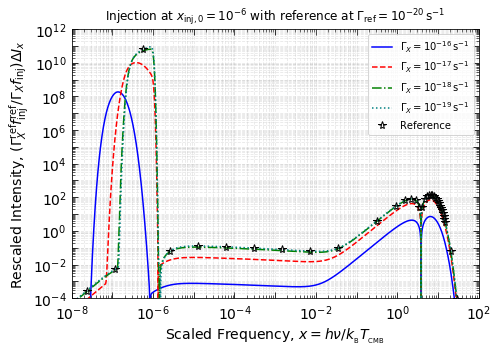

In [458]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale('log')
ax.set_yscale('log')
label_size = 14

R_ref = R_all_gammas[len(Gamma_values)-1][0]

Gamma_ref = Gamma_values[len(Gamma_values)-1]
print('Gamma_ref = %.4e'%Gamma_ref)


lss = iter(['-','--','-.',':','None'])
colors=iter(['b','r','g','teal','k'])
labels=iter([r'$\Gamma_X=10^{-16}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$',
            r'$\Gamma_X=10^{-18}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-19}\,\mathrm{s}^{-1}$',
            'Reference'])

jx = 0
for i in range(len(Gamma_values)):
    gamma = Gamma_values[i]
    R = R_all_gammas[i][0]
    R_no_inj= R_all_gammas[i][1]
    ls = next(lss)
    col = next(colors)
    label=next(labels)
    for j in range(len(xinj_values)):
        if j==jx:
            xinj = xinj_values[j]
            print('xinj=%.4e'%xinj)
            x = R[j]['x']
            f_inj = R[j]['finj']
            f_inj_ref = R_ref[j]['finj']
            norm_factor = Gamma_ref*f_inj_ref/gamma/f_inj


            try:
                DI = norm_factor*(R[j]['DI']-R_no_inj[j]['DI'])
                if i==(len(Gamma_values)-1):
                    ax.plot(x,DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col)
                else:
                    ax.plot(x,DI,ls=ls,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,c=col)



            except:
                print('problem  pour gamma=%.3e (i=%d) and xinj=%.3e (j=%d)'%(gamma,i,xinj,j))
                continue
        else:
            continue

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=3)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=3)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
title_size = 14
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.set_ylabel(r'Rescaled Intensity, $(\Gamma_X^\mathrm{ref}f_\mathrm{inj}^\mathrm{ref}/\Gamma_X f_\mathrm{inj})\Delta I_x$',size=title_size)
ax.yaxis.set_label_coords(-.1,0.5)
plt.title(r'Injection at $x_\mathrm{inj,0}=10^{-6}$ with reference at $\Gamma_\mathrm{ref}=10^{-20}\,\mathrm{s}^{-1}$',pad=9)
plt.ylim(1e-4,1e12)
plt.xlim(1e-8,1e2)
plt.legend(loc=1)
fig.tight_layout()
plt.savefig(path_to_figures+'figure_for_paper_QSP_xinj_1e-6.pdf')

Gamma_ref = 1.0000e-20
xinj=1.0000e-02
xinj=1.0000e-02
xinj=1.0000e-02
xinj=1.0000e-02
xinj=1.0000e-02


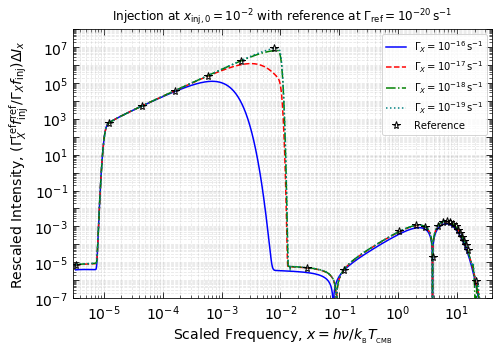

In [472]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale('log')
ax.set_yscale('log')
label_size = 14

R_ref = R_all_gammas[len(Gamma_values)-1][0]

Gamma_ref = Gamma_values[len(Gamma_values)-1]
print('Gamma_ref = %.4e'%Gamma_ref)


lss = iter(['-','--','-.',':','None'])
colors=iter(['b','r','g','teal','k'])
labels=iter([r'$\Gamma_X=10^{-16}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$',
            r'$\Gamma_X=10^{-18}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-19}\,\mathrm{s}^{-1}$',
            'Reference'])

jx = 1
for i in range(len(Gamma_values)):
    gamma = Gamma_values[i]
    R = R_all_gammas[i][0]
    R_no_inj= R_all_gammas[i][1]
    ls = next(lss)
    col = next(colors)
    label=next(labels)
    for j in range(len(xinj_values)):
        if j==jx:
            xinj = xinj_values[j]
            print('xinj=%.4e'%xinj)
            x = R[j]['x']
            f_inj = R[j]['finj']
            f_inj_ref = R_ref[j]['finj']
            norm_factor = Gamma_ref*f_inj_ref/gamma/f_inj


            try:
                DI = norm_factor*(R[j]['DI']-R_no_inj[j]['DI'])
                if i==(len(Gamma_values)-1):
                    ax.plot(x,DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col)
                else:
                    ax.plot(x,DI,ls=ls,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,c=col)



            except:
                print('problem  pour gamma=%.3e (i=%d) and xinj=%.3e (j=%d)'%(gamma,i,xinj,j))
                continue
        else:
            continue

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=3)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=3)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
title_size = 14
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.set_ylabel(r'Rescaled Intensity, $(\Gamma_X^\mathrm{ref}f_\mathrm{inj}^\mathrm{ref}/\Gamma_X f_\mathrm{inj})\Delta I_x$',size=title_size)
ax.yaxis.set_label_coords(-.1,0.5)
plt.title(r'Injection at $x_\mathrm{inj,0}=10^{-2}$ with reference at $\Gamma_\mathrm{ref}=10^{-20}\,\mathrm{s}^{-1}$',pad=9)
plt.ylim(1e-7,1e8)
plt.xlim(3e-6,4e1)
plt.legend(loc=1)
fig.tight_layout()
plt.savefig(path_to_figures+'figure_for_paper_QSP_xinj_1e-2.pdf')

Gamma_ref = 1.0000e-20
xinj=1.0000e+00
xinj=1.0000e+00
xinj=1.0000e+00
xinj=1.0000e+00
xinj=1.0000e+00


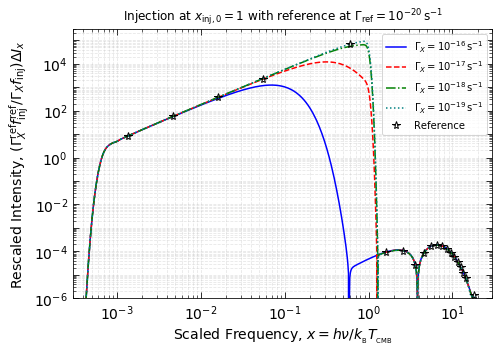

In [476]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale('log')
ax.set_yscale('log')
label_size = 14

R_ref = R_all_gammas[len(Gamma_values)-1][0]

Gamma_ref = Gamma_values[len(Gamma_values)-1]
print('Gamma_ref = %.4e'%Gamma_ref)


lss = iter(['-','--','-.',':','None'])
colors=iter(['b','r','g','teal','k'])
labels=iter([r'$\Gamma_X=10^{-16}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$',
            r'$\Gamma_X=10^{-18}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-19}\,\mathrm{s}^{-1}$',
            'Reference'])

jx = 3
for i in range(len(Gamma_values)):
    gamma = Gamma_values[i]
    R = R_all_gammas[i][0]
    R_no_inj= R_all_gammas[i][1]
    ls = next(lss)
    col = next(colors)
    label=next(labels)
    for j in range(len(xinj_values)):
        if j==jx:
            xinj = xinj_values[j]
            print('xinj=%.4e'%xinj)
            x = R[j]['x']
            f_inj = R[j]['finj']
            f_inj_ref = R_ref[j]['finj']
            norm_factor = Gamma_ref*f_inj_ref/gamma/f_inj


            try:
                DI = norm_factor*(R[j]['DI']-R_no_inj[j]['DI'])
                if i==(len(Gamma_values)-1):
                    ax.plot(x,DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col)
                else:
                    ax.plot(x,DI,ls=ls,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,c=col)



            except:
                print('problem  pour gamma=%.3e (i=%d) and xinj=%.3e (j=%d)'%(gamma,i,xinj,j))
                continue
        else:
            continue

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=3)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=3)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
title_size = 14
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.set_ylabel(r'Rescaled Intensity, $(\Gamma_X^\mathrm{ref}f_\mathrm{inj}^\mathrm{ref}/\Gamma_X f_\mathrm{inj})\Delta I_x$',size=title_size)
ax.yaxis.set_label_coords(-.1,0.5)
plt.title(r'Injection at $x_\mathrm{inj,0}=1$ with reference at $\Gamma_\mathrm{ref}=10^{-20}\,\mathrm{s}^{-1}$',pad=9)
plt.ylim(1e-6,3e5)
plt.xlim(3e-4,3e1)
plt.legend(loc=1)
fig.tight_layout()
plt.savefig(path_to_figures+'figure_for_paper_QSP_xinj_1e0.pdf')

Gamma_ref = 1.0000e-20
xinj=1.0000e+04
xinj=1.0000e+04
xinj=1.0000e+04
xinj=1.0000e+04
xinj=1.0000e+04


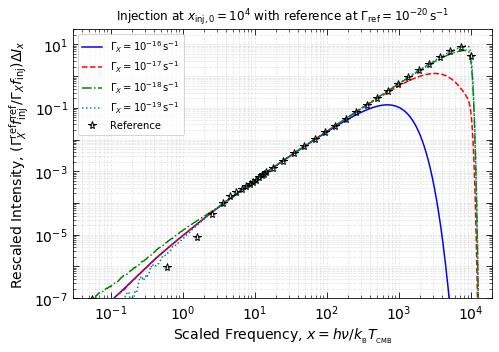

In [490]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale('log')
ax.set_yscale('log')
label_size = 14

R_ref = R_all_gammas[len(Gamma_values)-1][0]

Gamma_ref = Gamma_values[len(Gamma_values)-1]
print('Gamma_ref = %.4e'%Gamma_ref)


lss = iter(['-','--','-.',':','None'])
colors=iter(['b','r','g','teal','k'])
labels=iter([r'$\Gamma_X=10^{-16}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$',
            r'$\Gamma_X=10^{-18}\,\mathrm{s}^{-1}$',r'$\Gamma_X=10^{-19}\,\mathrm{s}^{-1}$',
            'Reference'])

jx = 5
for i in range(len(Gamma_values)):
    gamma = Gamma_values[i]
    R = R_all_gammas[i][0]
    R_no_inj= R_all_gammas[i][1]
    ls = next(lss)
    col = next(colors)
    label=next(labels)
    for j in range(len(xinj_values)):
        if j==jx:
            xinj = xinj_values[j]
            print('xinj=%.4e'%xinj)
            x = R[j]['x']
            f_inj = R[j]['finj']
            f_inj_ref = R_ref[j]['finj']
            norm_factor = Gamma_ref*f_inj_ref/gamma/f_inj


            try:
                DI = norm_factor*(R[j]['DI']-R_no_inj[j]['DI'])
                if i==(len(Gamma_values)-1):
                    ax.plot(x,DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,marker='*',markerfacecolor='None',markersize=8,markevery=100,c=col)
                else:
                    ax.plot(x,DI,ls=ls,c=col,label=label)
                    ax.plot(x,-DI,ls=ls,c=col)



            except:
                print('problem  pour gamma=%.3e (i=%d) and xinj=%.3e (j=%d)'%(gamma,i,xinj,j))
                continue
        else:
            continue

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=3)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=3)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=6,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
title_size = 14
ax.set_xlabel(label_scaled_frequency,size=title_size)
ax.set_ylabel(r'Rescaled Intensity, $(\Gamma_X^\mathrm{ref}f_\mathrm{inj}^\mathrm{ref}/\Gamma_X f_\mathrm{inj})\Delta I_x$',size=title_size)
ax.yaxis.set_label_coords(-.1,0.5)
plt.title(r'Injection at $x_\mathrm{inj,0}=10^{4}$ with reference at $\Gamma_\mathrm{ref}=10^{-20}\,\mathrm{s}^{-1}$',pad=9)
plt.ylim(1e-7,3e1)
plt.xlim(3e-2,2e4)
plt.legend(loc=2)
fig.tight_layout()
plt.savefig(path_to_figures+'figure_for_paper_QSP_xinj_1e4.pdf')

In [484]:
np.shape(R_all_gammas[4][0][5]['x'])

(4679,)

In [415]:
np.shape(R_all_gammas[4][1][3]['x'])

(2940,)

In [420]:
R_all_gammas[4][1][3].values()

dict_values([1.0, array([1.00000000e-05, 1.01237277e-05, 1.02489862e-05, ...,
       1.49003649e+02, 1.49500994e+02, 1.50000000e+02]), array([3.89724657e-01, 3.89600090e-01, 3.89470642e-01, ...,
       1.51825354e-53, 9.38935536e-54, 5.79692135e-54]), array([4.99925e+06, 4.99813e+06, 4.99644e+06, 4.99391e+06, 4.99012e+06,
       4.98443e+06, 4.97592e+06, 4.96316e+06, 4.94408e+06, 4.91557e+06,
       4.87305e+06, 4.80983e+06, 4.71622e+06, 4.57854e+06, 4.37805e+06,
       4.09048e+06, 3.78369e+06, 3.49992e+06, 3.23742e+06, 2.99462e+06,
       2.77002e+06, 2.56227e+06, 2.37010e+06, 2.19234e+06, 2.02792e+06,
       1.87582e+06, 1.73514e+06, 1.60500e+06, 1.48463e+06, 1.37328e+06,
       1.27028e+06, 1.17501e+06, 1.08689e+06, 1.00537e+06, 9.29966e+05,
       8.60219e+05, 7.95702e+05, 7.36025e+05, 6.80823e+05, 6.29761e+05,
       5.82529e+05, 5.38839e+05, 4.98426e+05, 4.83474e+05, 4.68969e+05,
       4.54900e+05, 4.41253e+05, 4.28016e+05, 4.15175e+05, 4.02720e+05,
       3.90638e+05, 3.78919e

# update of the figures with many spectra

In [374]:
sd_lib_raw_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('raw_lyc_reio',sd_lib_raw_lyc_reio)

sd_lib_bare = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('bare',sd_lib_bare)


sd_lib_lyc = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




In [376]:
firas = sd.firas()

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea09bdc128>


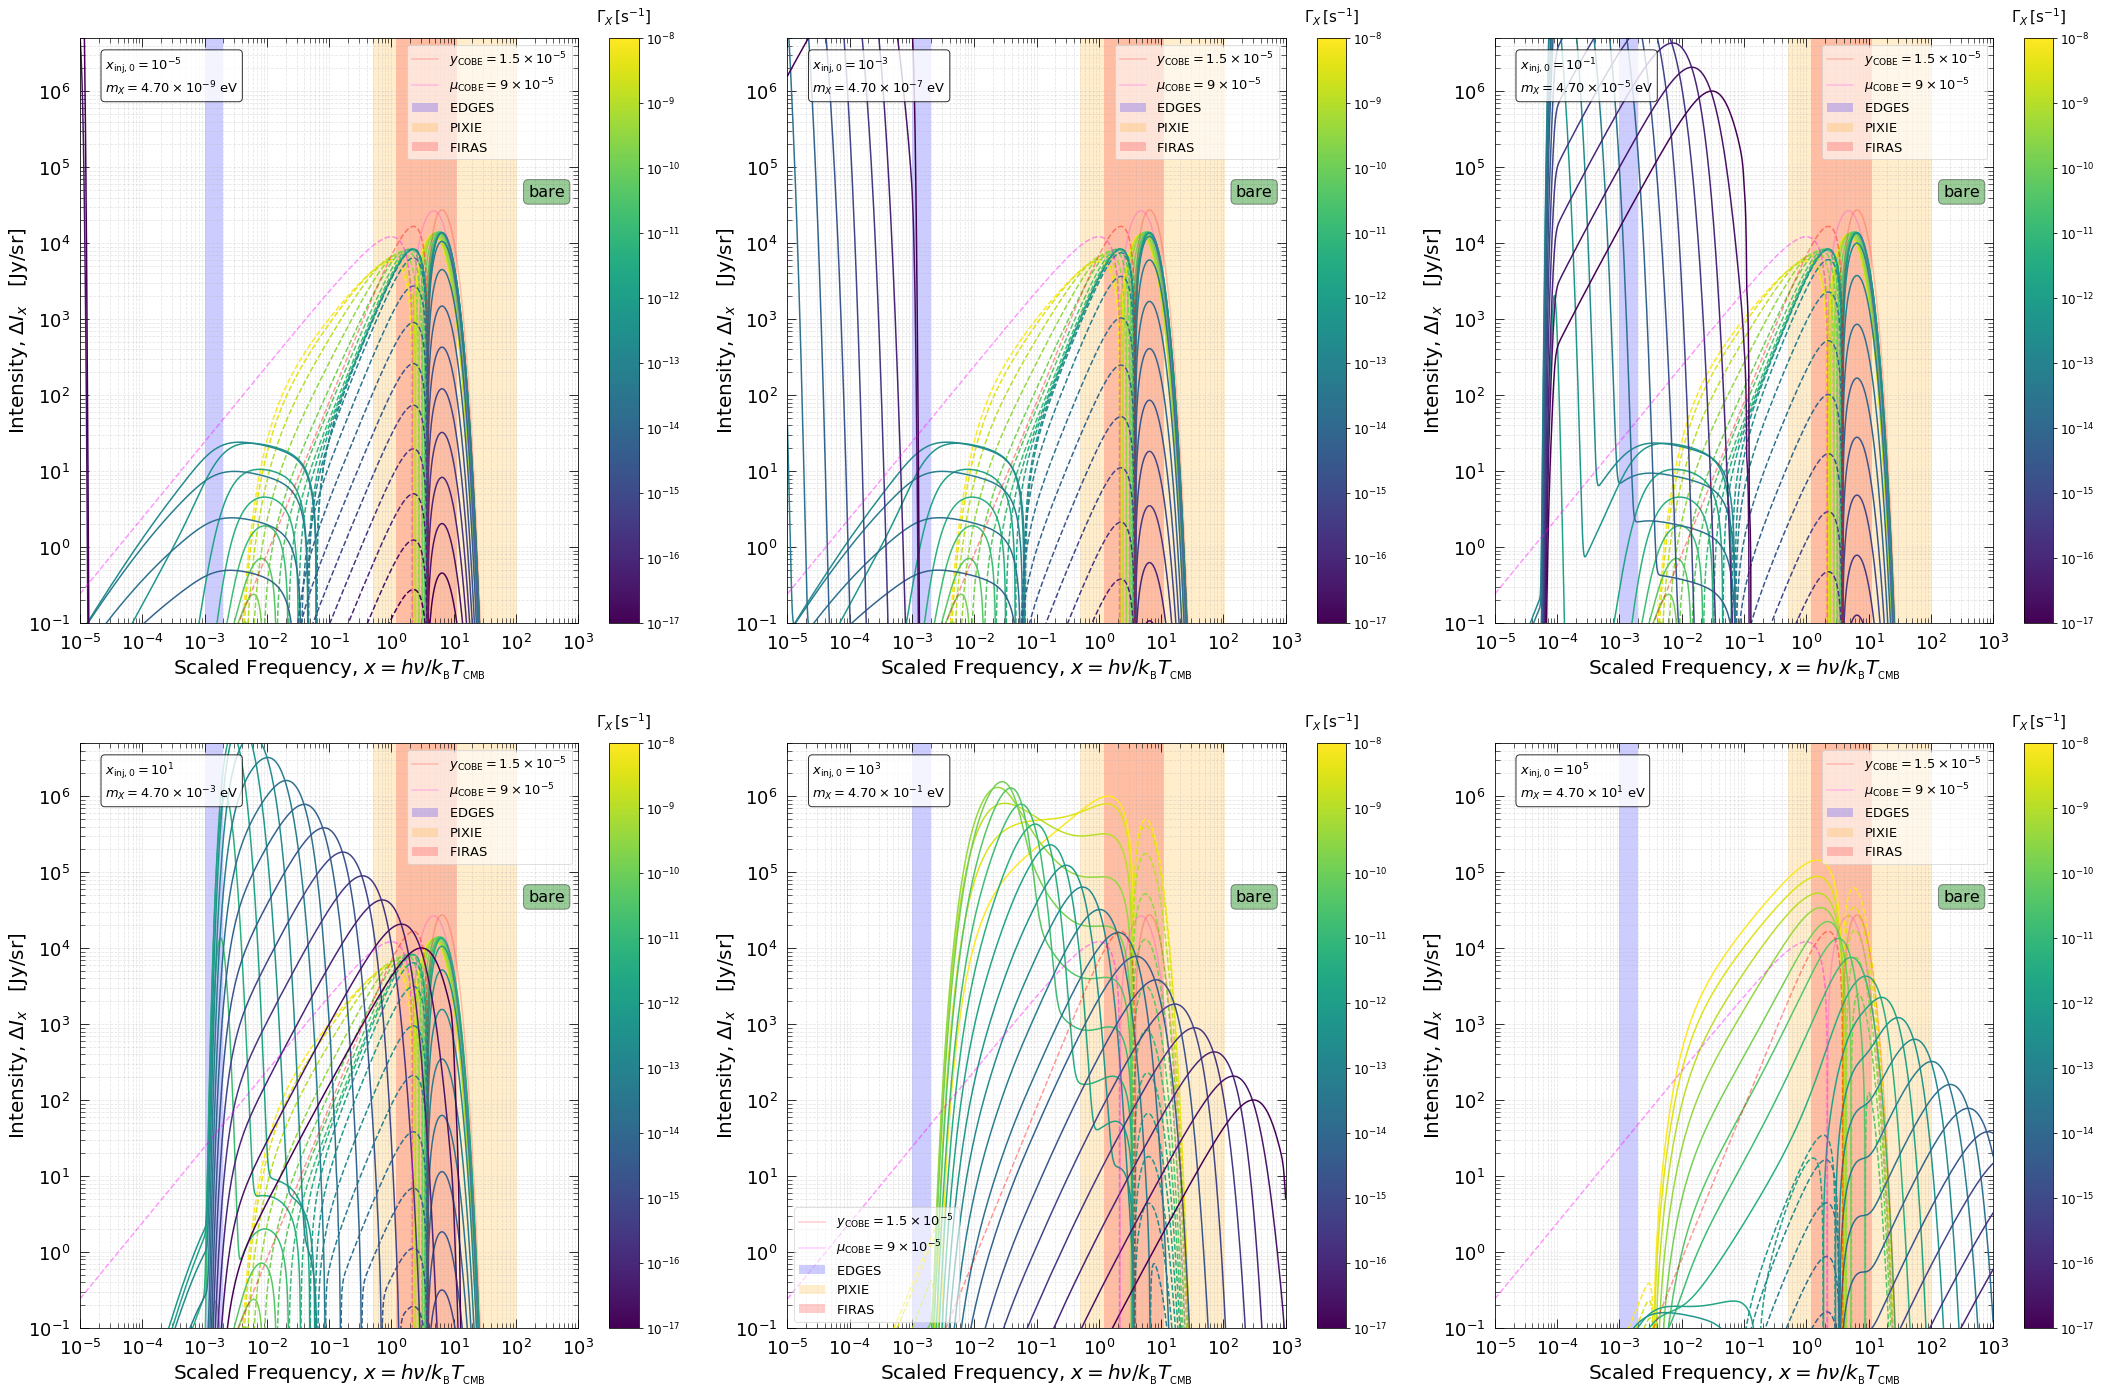

In [391]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)

xinj_asked_array = [1.e-5,1e-3,1e-1,1e1,1e3,1e5]

# x_min = 1.e-6
# x_max = 1.5e4
# ymin = 1.e-18
# ymax = 1.5e-3
x_min = 1.e-5
x_max = 1.e3
ymin = 1.e-1
ymax = 5e-6*1e6*1e6

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 18
title_size = 20
legend_size = 25
handle_length = 1.5
my_cmap =  cm.get_cmap('viridis')
#my_cmap = my_cmap(np.linspace(0.,0.5,ngamma))
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax) in zip(xinj_asked_array,ax_array.reshape(-1)):



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)
    
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=12)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=15,pad=15)





#     ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
#     ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

#     plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
#     plt.setp(ax.get_xticklabels(), fontsize=label_size)
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
#     majors = [0, 1, 5]
# #     majors = [0, 1, 5]
#    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False) #(3)


#     ax.xaxis.set_ticks_position('both')
#     ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
#                                           numticks=12)
#     ax.xaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    #ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    color=iter(cm.viridis(np.linspace(1.,0.,ngamma)))

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    str_m_dec_in_ev =  str("%.3e"%m_dec_in_ev)
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'

    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_bare)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()

    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.05, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=13, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.2,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.2,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)

        
    if xinj_asked==1e3:
        lloc = 3
    else:
        lloc =1
    legend1 = ax.legend(loc=lloc,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)

    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    case_type = 'bare'
    case_color ='green'
    ax.text(0.9, 0.75, case_type, transform=ax.transAxes, fontsize=16, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.4))

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_bare_final_version.pdf')
plt.show()
plt.close(fig)




[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea11124f60>


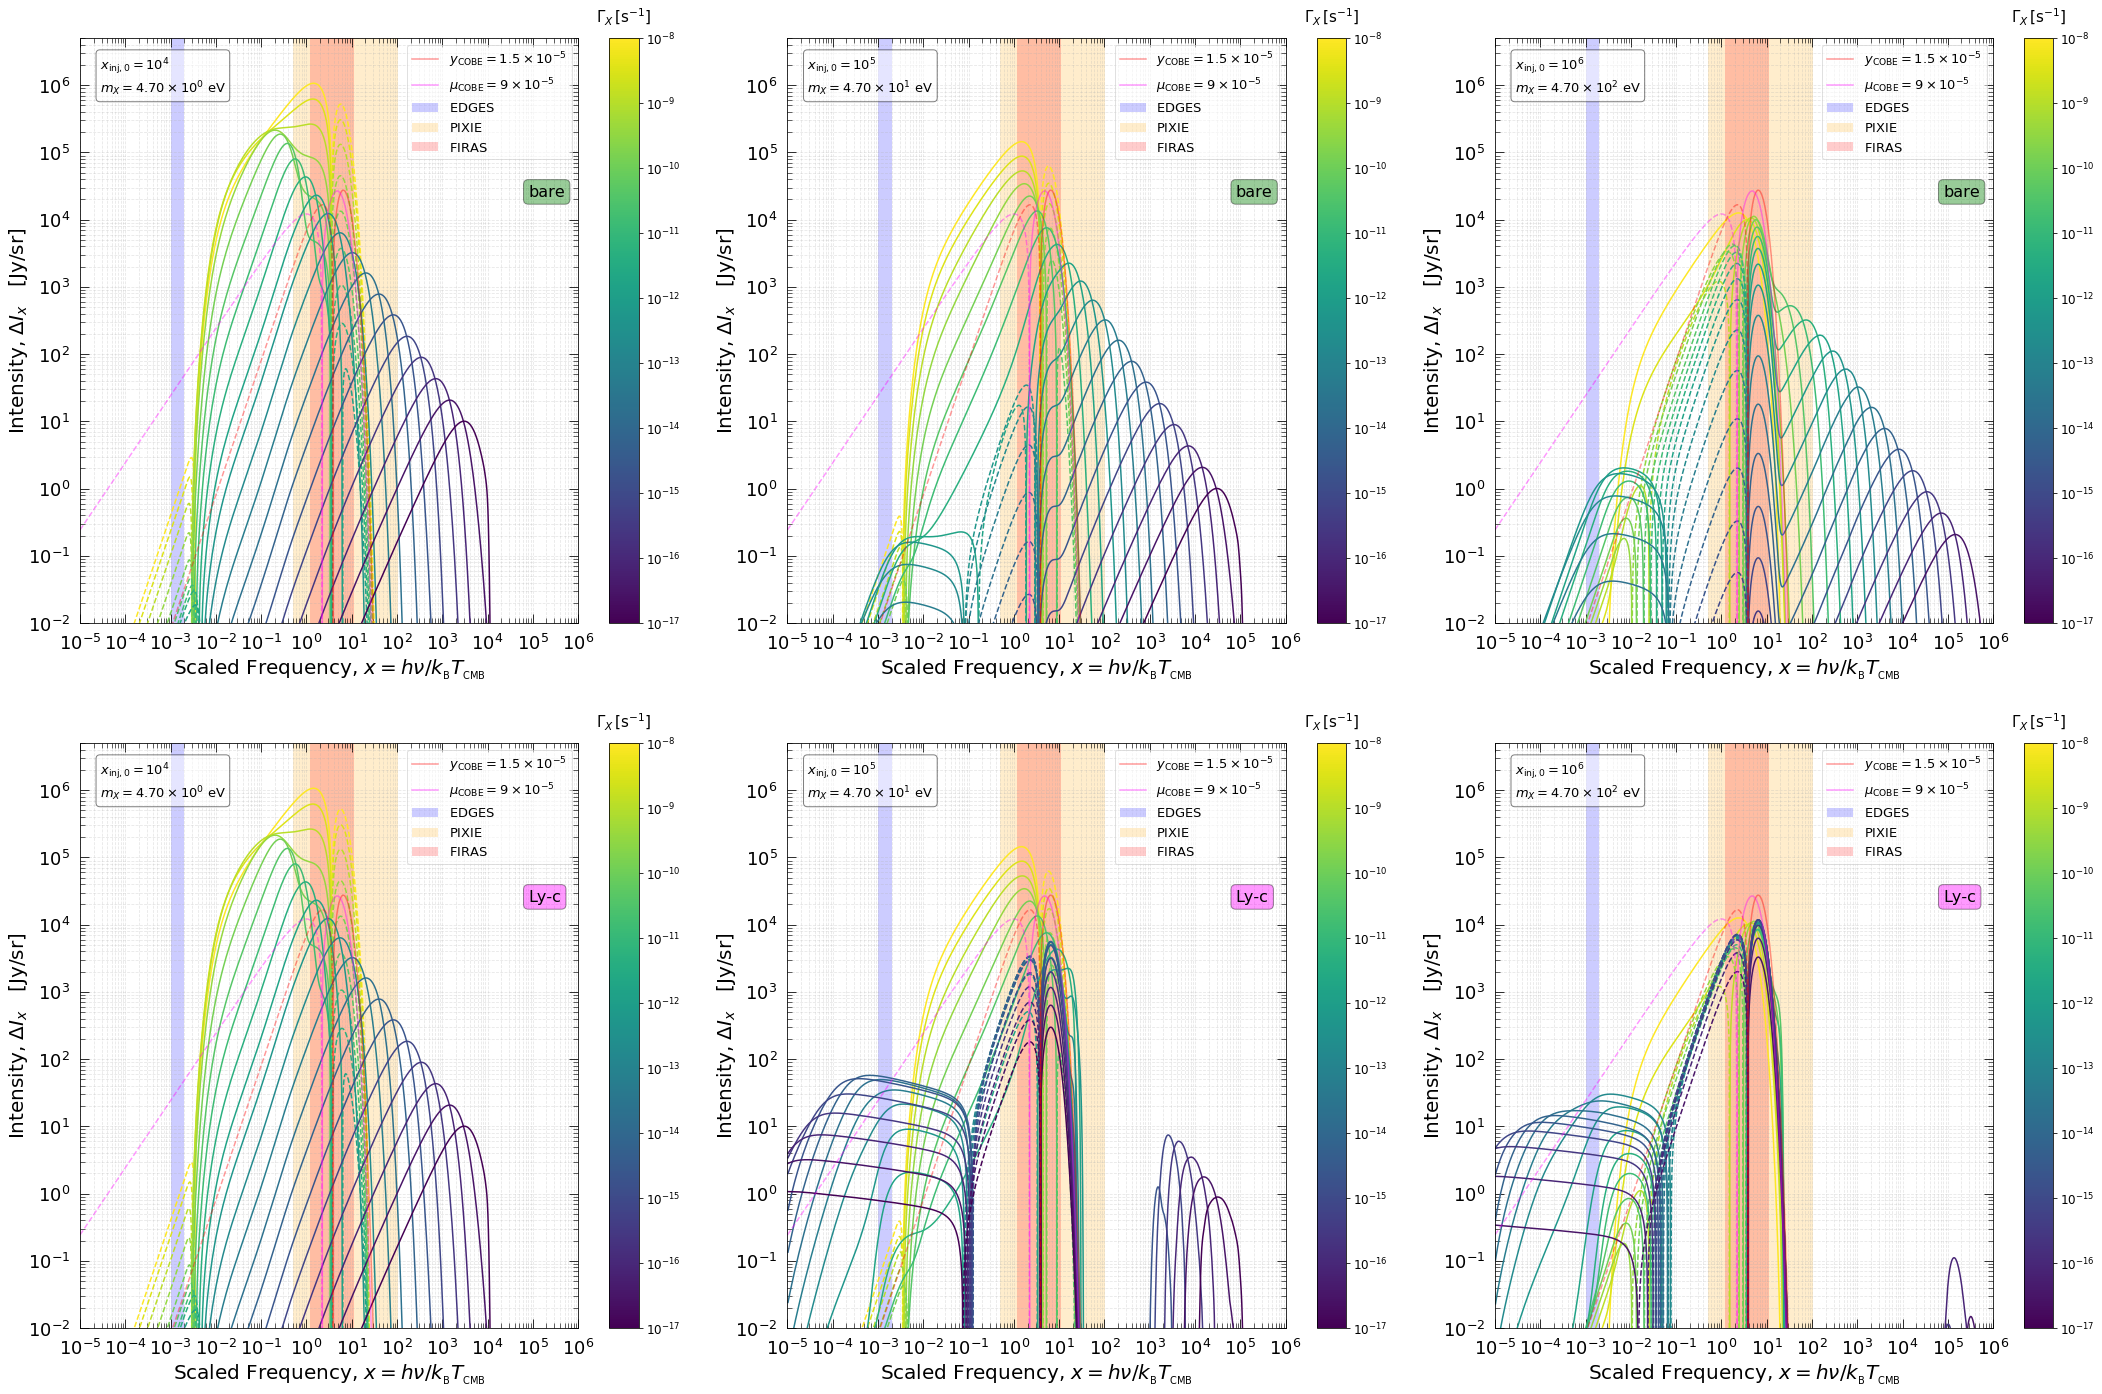

In [390]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)
xinj_to_mass = 4.698e-4 #in ev
xinj_asked_array = [1.e4,1e5,1e6,1.e4,1e5,1e6]

x_min = 1.e-5
x_max = 1.e6
ymin = 1.e-14*1e12
ymax = 5e-6*1e12

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 18
title_size = 20
legend_size = 25
handle_length = 1.5

my_cmap =  cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax,iax) in zip(xinj_asked_array,ax_array.reshape(-1),np.arange(6)):
    if iax in (0,1,2):
        sd_lib = sd_lib_bare
        color=iter(cm.viridis(np.linspace(1,0,ngamma)))
        case_type = 'bare'
        case_color ='green'
    else:
        sd_lib = sd_lib_lyc
        color=iter(cm.viridis(np.linspace(1,0,ngamma)))
        case_type = 'Ly-c'
        case_color ='magenta'
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=12)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=15,pad=15)



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')

    
    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)


        
    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'
    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()
    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.04, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=13, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    
    ax.text(0.9, 0.75, case_type, transform=ax.transAxes, fontsize=16, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.4))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.4,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.4,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)
    
    legend1 = ax.legend(loc=1,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_bare_vs_lyc_final_version.pdf')
plt.show()
plt.close(fig)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea1181c4a8>


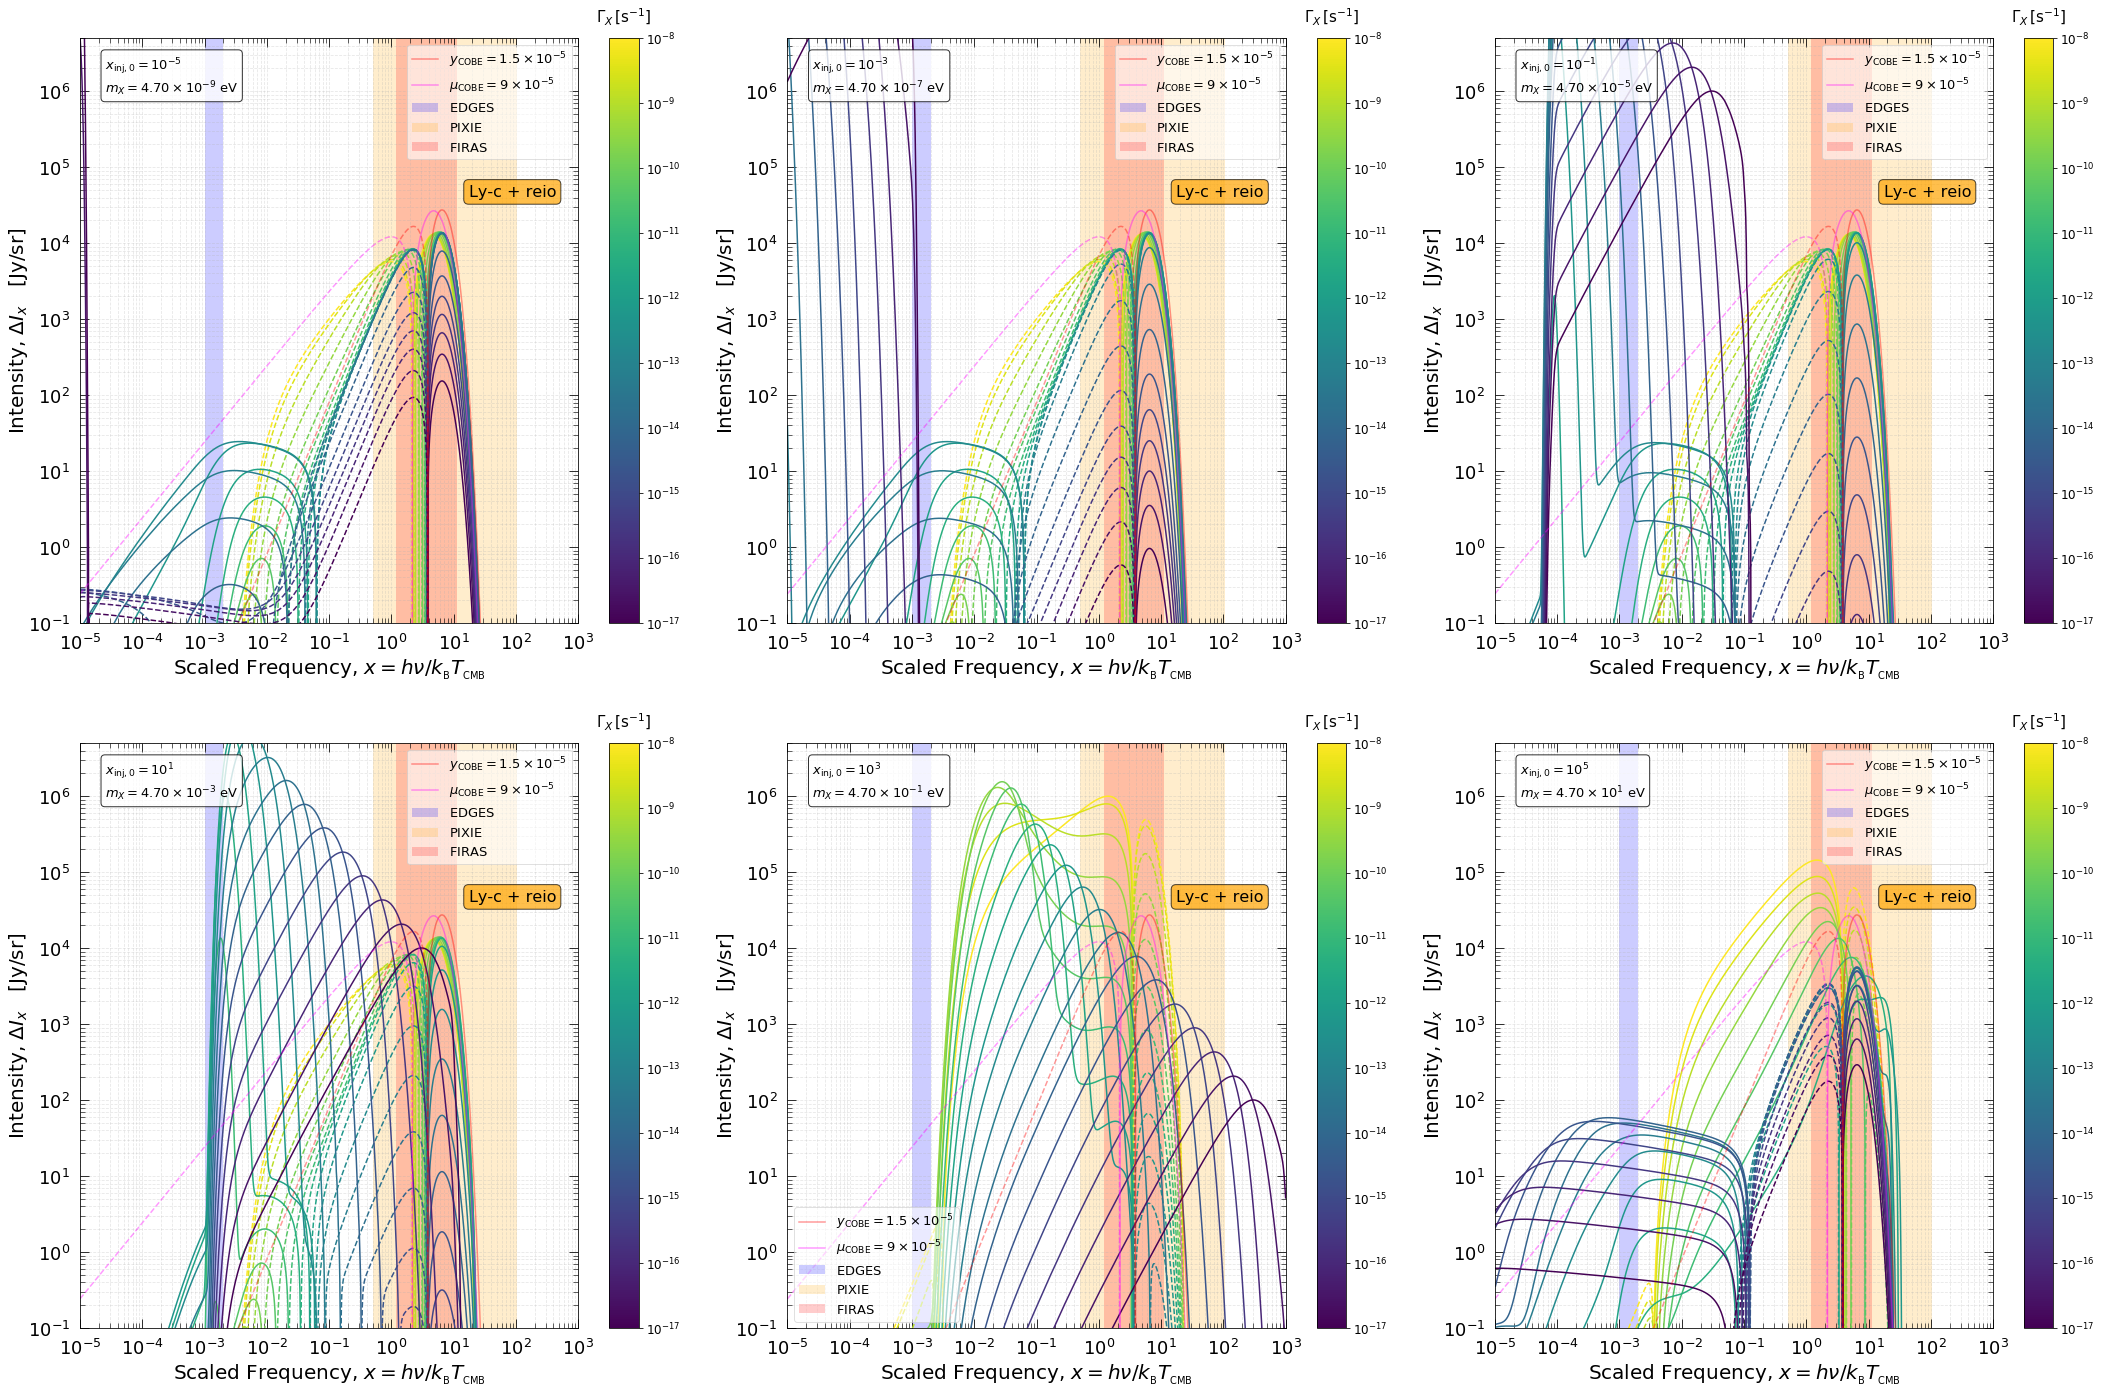

In [396]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)

xinj_asked_array = [1.e-5,1e-3,1e-1,1e1,1e3,1e5]

# x_min = 1.e-6
# x_max = 1.5e4
# ymin = 1.e-18
# ymax = 1.5e-3
x_min = 1.e-5
x_max = 1.e3
ymin = 1.e-1
ymax = 5e-6*1e6*1e6

ngamma = 20


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 18
title_size = 20
legend_size = 25
handle_length = 1.5
my_cmap =  cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax) in zip(xinj_asked_array,ax_array.reshape(-1)):



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)
    
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=12)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=15,pad=15)





#     ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
#     ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

#     plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
#     plt.setp(ax.get_xticklabels(), fontsize=label_size)
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
#     majors = [0, 1, 5]
# #     majors = [0, 1, 5]
#    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False) #(3)


#     ax.xaxis.set_ticks_position('both')
#     ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
#                                           numticks=12)
#     ax.xaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    #ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    color=iter(cm.viridis(np.linspace(1,0,ngamma)))

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    str_m_dec_in_ev =  str("%.3e"%m_dec_in_ev)
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'

    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()

    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.05, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=13, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.4,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.4)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.4,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.4)
    
    
    if xinj_asked==1e3:
        lloc = 3
    else:
        lloc =1
    legend1 = ax.legend(loc=lloc,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)

    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    case_type = 'Ly-c + reio'
    case_color ='orange'
    ax.text(0.78, 0.75, case_type, transform=ax.transAxes, fontsize=16, verticalalignment='top',
      bbox=dict(boxstyle='round', facecolor=case_color, alpha=0.7))
        
    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
plt.savefig(path_to_figures + '/spectra_for_paper_xinj_lyc_reio_final_version.pdf')
plt.show()
plt.close(fig)




# reio with recfast
scaling of DXe_Xe with fdm at xinj = 1e-8 and Gamma = 1e-15 /s

In [161]:
# just setting the cosmology and ct objects:

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_Gamma_dec = 1e-15
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

In [162]:
# initial setup of recfast
a_dict = {}
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 5e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 1

rf.rf_Reionization_model = 0

rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422
a_dict['recfast'] = rf

In [227]:
#fdm = 1e-1
fdm_array =  np.concatenate((np.asarray([1e-100]),np.logspace(-10,-6,20)))

#fdm =  1.3098e4*fdm/xdec

rf.rf_xinj0 = 1e-8
rf.rf_f_dec = fdm
rf.rf_Gamma_dec = 1e-17

args = {}

#p_name = 'Gamma_dec'
p_name = 'f_dec'
#p_array = gi_array
p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R = rf.run_recfast_parallel(**args)

In [228]:
DXe_Xe_at_zp = []
zp = 50
for i in range(len(fdm_array)):
    if i==0:
        continue
    z = R[i]['z']
    DXe_Xe = (R[i]['Xe'] - R[0]['Xe'])/R[0]['Xe']
    fXe = interp1d(z,DXe_Xe)
    DXe_Xe_at_zp.append(fXe(zp))
    
DXe_Xe_at_zp = np.asarray(DXe_Xe_at_zp)

In [229]:
from scipy import stats
x = np.log(fdm_array[1:])
y = np.log(DXe_Xe_at_zp)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope)
print(np.exp(intercept))

0.43205746986777366
536.6583360998454


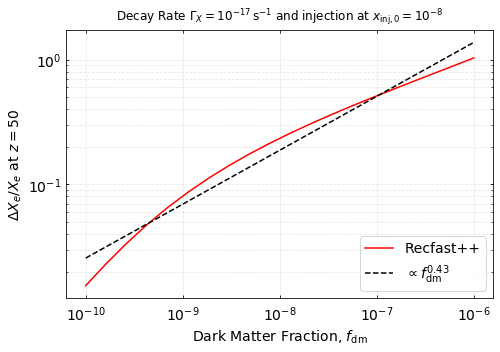

In [230]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 14
title_size = 13
legend_size = 25
handle_length = 1.5
ax.plot(fdm_array[1:],DXe_Xe_at_zp,c='r',ls='-',label='Recfast++')
ax.plot(fdm_array[1:],np.exp(intercept)*fdm_array[1:]**slope,ls='--',c='k',label=r'$\propto f_\mathrm{dm}^{0.43}$')
#ax.plot(fdm_array[1:],fdm_array[1:],ls='--')
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
ax.set_xlabel('Dark Matter Fraction, $f_\mathrm{dm}$',fontsize=label_size)
ax.set_ylabel(r'$\Delta X_e/X_e$ at $z=50$',fontsize=label_size)

plt.title(r'Decay Rate $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$',pad=10.)
ax.legend(loc=4,ncol=1,fontsize=14)

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_DXe_scaling_G_1e-17_fdm.pdf')
plt.show()
plt.close(fig)

# scaling with the integrated mode

In [240]:
pca_modes = sd.Xe_PCA_EigenModes()
z1 = pca_modes.Xe_PCA_EigenModes['E1']['z']
z2 = pca_modes.Xe_PCA_EigenModes['E2']['z']
z3 = pca_modes.Xe_PCA_EigenModes['E3']['z']
e1 = pca_modes.Xe_PCA_EigenModes['E1']['values']
e2 = pca_modes.Xe_PCA_EigenModes['E2']['values']
e3 = pca_modes.Xe_PCA_EigenModes['E3']['values']
f_E1 = interp1d(z1, e1,bounds_error=False, fill_value=0.)
f_E2 = interp1d(z2, e2,bounds_error=False, fill_value=0.)
f_E3 = interp1d(z3, e3,bounds_error=False, fill_value=0.)

In [234]:
# just setting the cosmology and ct objects:

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_Gamma_dec = 1e-15
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

In [241]:
# initial setup of recfast
a_dict = {}
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 5e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 1

rf.rf_Reionization_model = 0

rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422
a_dict['recfast'] = rf

In [309]:
#fdm = 1e-1
fdm_array =  np.concatenate((np.asarray([1e-100]),np.logspace(-10,-6,50)))

#fdm =  1.3098e4*fdm/xdec

rf.rf_xinj0 = 1e-8
rf.rf_f_dec = fdm
rf.rf_Gamma_dec = 1e-13

args = {}

#p_name = 'Gamma_dec'
p_name = 'f_dec'
#p_array = gi_array
p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R = rf.run_recfast_parallel(**args)

In [310]:
rho1 = []
rho2 = []
rho3 = []
#zp = 50
for i in range(len(fdm_array)):
    if i==0:
        continue
    z = R[i]['z']
    DXe_Xe = (R[i]['Xe'] - R[0]['Xe'])/R[0]['Xe']
    fXe = interp1d(z,DXe_Xe)
    
    min_z1 = max(np.min(z1),np.min(z))
    max_z1 = min(np.max(z1),np.max(z))

    min_z2 = max(np.min(z2),np.min(z))
    max_z2 = min(np.max(z2),np.max(z))

    min_z3 = max(np.min(z3),np.min(z))
    max_z3 = min(np.max(z3),np.max(z))

    new_z1 = np.logspace(np.log10(min_z1),np.log10(max_z1),5000)
    new_z2 = np.logspace(np.log10(min_z2),np.log10(max_z2),5000)
    new_z3 = np.logspace(np.log10(min_z3),np.log10(max_z3),5000)

    zeta1 = fXe(new_z1) #DXe_Xe @ z1
    zeta2 = fXe(new_z2) #DXe_Xe @ z2
    zeta3 = fXe(new_z3) #DXe_Xe @ z3



    integrand_rho1 = zeta1*f_E1(new_z1)
    integrand_rho2 = zeta2*f_E2(new_z2)
    integrand_rho3 = zeta3*f_E3(new_z3)

    rho1.append(np.trapz(integrand_rho1, x=new_z1))
    rho2.append(np.trapz(integrand_rho2, x=new_z2))
    rho3.append(np.trapz(integrand_rho3, x=new_z3))
rho1 = np.asarray(rho1)
rho2 = np.asarray(rho2)
rho3 = np.asarray(rho3)
    #DXe_Xe_at_zp = np.asarray(rho)

In [311]:
from scipy import stats
x = fdm_array[1:]
y = rho1
slope1, intercept1, r_value, p_value, std_err = stats.linregress(x,y)
print(slope1)
print(intercept1)
y = rho2
slope2, intercept2, r_value, p_value, std_err = stats.linregress(x,y)
print(slope2)
print(intercept2)
y = rho3
slope3, intercept3, r_value, p_value, std_err = stats.linregress(x,y)
print(slope3)
print(intercept3)

-1619765.4782362992
-0.0033587115439009108
4987782.890811361
0.1365535728775329
-12160888.774940506
-0.3847043503367653


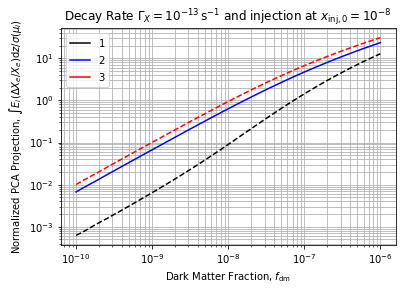

In [312]:
plt.plot(fdm_array[1:],rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],c='k',label=r'$1$')
plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
plt.plot(fdm_array[1:],rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],c='b',label=r'$2$')
plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
plt.plot(fdm_array[1:],rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],c='r',label=r'$3$')
plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.loglog()
plt.grid(which='both')
plt.legend(loc=2)
plt.xlabel(r'Dark Matter Fraction, $f_\mathrm{dm}$')
plt.ylabel(r'Normalized PCA Projection, $\int E_i (\Delta X_e/X_e)\mathrm{d}z/\sigma(\mu_i)$')
plt.title('Decay Rate $\Gamma_X=10^{-13}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$')
plt.savefig(path_to_figures+'normalized_pca_projection_G_1e-13.pdf')
#plt.plot(fdm_array[1:],slope1*fdm_array[1:]+intercept1,ls='--',c='k')

# plotting the pca modes $E_i$ and integrand

In [323]:
#fdm = 1e-1
fdm_array =  np.concatenate((np.asarray([1e-100]),np.asarray([1e-6])))

#fdm =  1.3098e4*fdm/xdec

rf.rf_xinj0 = 1e-8
rf.rf_f_dec = fdm
rf.rf_Gamma_dec = 1e-15

args = {}

#p_name = 'Gamma_dec'
p_name = 'f_dec'
#p_array = gi_array
p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R = rf.run_recfast_parallel(**args)

In [324]:
rho1 = []
rho2 = []
rho3 = []
#zp = 50
for i in range(len(fdm_array)):
    if i==0:
        continue
    z = R[i]['z']
    DXe_Xe = (R[i]['Xe'] - R[0]['Xe'])/R[0]['Xe']
    fXe = interp1d(z,DXe_Xe)
    
    min_z1 = max(np.min(z1),np.min(z))
    max_z1 = min(np.max(z1),np.max(z))

    min_z2 = max(np.min(z2),np.min(z))
    max_z2 = min(np.max(z2),np.max(z))

    min_z3 = max(np.min(z3),np.min(z))
    max_z3 = min(np.max(z3),np.max(z))

    new_z1 = np.logspace(np.log10(min_z1),np.log10(max_z1),5000)
    new_z2 = np.logspace(np.log10(min_z2),np.log10(max_z2),5000)
    new_z3 = np.logspace(np.log10(min_z3),np.log10(max_z3),5000)

    zeta1 = fXe(new_z1) #DXe_Xe @ z1
    zeta2 = fXe(new_z2) #DXe_Xe @ z2
    zeta3 = fXe(new_z3) #DXe_Xe @ z3



    integrand_rho1 = zeta1*f_E1(new_z1)
    integrand_rho2 = zeta2*f_E2(new_z2)
    integrand_rho3 = zeta3*f_E3(new_z3)

    rho1.append(np.trapz(integrand_rho1, x=new_z1))
    rho2.append(np.trapz(integrand_rho2, x=new_z2))
    rho3.append(np.trapz(integrand_rho3, x=new_z3))
rho1 = np.asarray(rho1)
rho2 = np.asarray(rho2)
rho3 = np.asarray(rho3)
    #DXe_Xe_at_zp = np.asarray(rho)

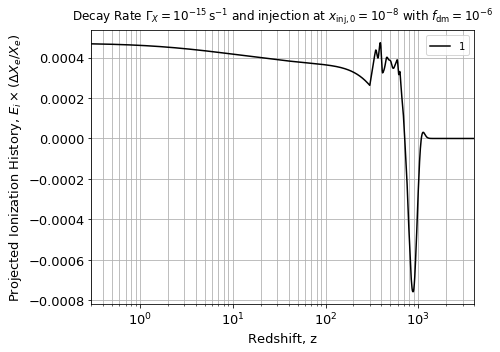

In [349]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(new_z1,integrand_rho1,c='k',label=r'$1$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e-1,4e3)
plt.grid(which='both')
plt.legend(loc=1)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel(r'Redshift, z',fontsize=13)
plt.ylabel(r'Projected Ionization History, $E_i\times(\Delta X_e/X_e)$',fontsize=13)
plt.title('Decay Rate $\Gamma_X=10^{-15}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$ with $f_\mathrm{dm}=10^{-6}$',pad=10)
fig.tight_layout()
plt.savefig(path_to_figures+'pca_pmodes_projected_1.pdf')

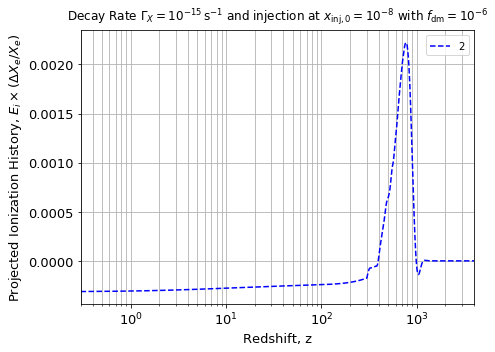

In [350]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(new_z2,integrand_rho2,c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e-1,4e3)
plt.grid(which='both')
plt.legend(loc=1)
plt.xlabel(r'Redshift, z',fontsize=13)
plt.ylabel(r'Projected Ionization History, $E_i\times(\Delta X_e/X_e)$',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Decay Rate $\Gamma_X=10^{-15}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$ with $f_\mathrm{dm}=10^{-6}$',pad=10)
fig.tight_layout()
plt.savefig(path_to_figures+'pca_pmodes_projected_2.pdf')

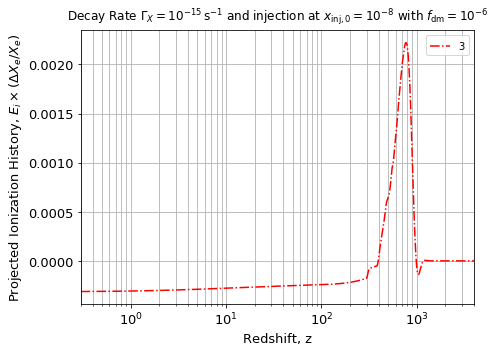

In [353]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
plt.plot(new_z2,integrand_rho2,c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e-1,4e3)
plt.grid(which='both')
plt.legend(loc=1)
plt.xlabel(r'Redshift, z',fontsize=13)
plt.ylabel(r'Projected Ionization History, $E_i\times(\Delta X_e/X_e)$',fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Decay Rate $\Gamma_X=10^{-15}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$ with $f_\mathrm{dm}=10^{-6}$',pad=10)
fig.tight_layout()
plt.savefig(path_to_figures+'pca_pmodes_projected_3.pdf')

In [331]:
new_z1[0]

1e-05

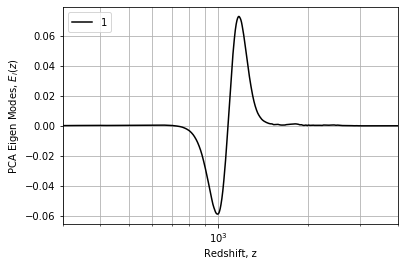

In [319]:
plt.plot(pca_modes.Xe_PCA_EigenModes['E1']['z'],pca_modes.Xe_PCA_EigenModes['E1']['values'],c='k',label=r'$1$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e2,4e3)
plt.grid(which='both')
plt.legend(loc=2)
plt.xlabel(r'Redshift, z')
plt.ylabel(r'PCA Eigen Modes, $E_i(z)$')
#plt.title('Decay Rate $\Gamma_X=10^{-13}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$')
plt.savefig(path_to_figures+'pca_pmodes_1.pdf')

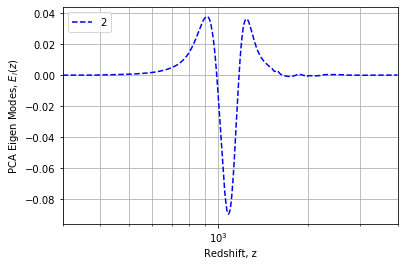

In [320]:
#plt.plot(pca_modes.Xe_PCA_EigenModes['E1']['z'],pca_modes.Xe_PCA_EigenModes['E1']['values'],c='k',label=r'$1$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e2,4e3)
plt.grid(which='both')
plt.legend(loc=2)
plt.xlabel(r'Redshift, z')
plt.ylabel(r'PCA Eigen Modes, $E_i(z)$')
#plt.title('Decay Rate $\Gamma_X=10^{-13}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$')
plt.savefig(path_to_figures+'pca_pmodes_2.pdf')

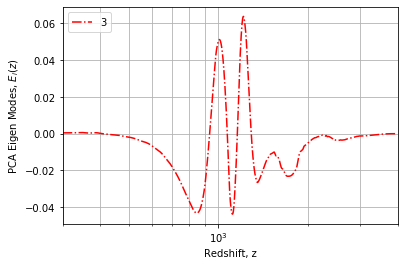

In [321]:
#plt.plot(pca_modes.Xe_PCA_EigenModes['E1']['z'],pca_modes.Xe_PCA_EigenModes['E1']['values'],c='k',label=r'$1$')
#plt.plot(fdm_array[1:],-rho1/pca_modes.Xe_PCA_EigenModes['E1']['sigma1'],ls='--',c='k')
#plt.plot(pca_modes.Xe_PCA_EigenModes['E2']['z'],pca_modes.Xe_PCA_EigenModes['E2']['values'],c='b',ls='--',label=r'$2$')
#plt.plot(fdm_array[1:],-rho2/pca_modes.Xe_PCA_EigenModes['E2']['sigma2'],ls='--',c='b')
plt.plot(pca_modes.Xe_PCA_EigenModes['E3']['z'],pca_modes.Xe_PCA_EigenModes['E3']['values'],c='r',ls='-.',label=r'$3$')
#plt.plot(fdm_array[1:],-rho3/pca_modes.Xe_PCA_EigenModes['E3']['sigma3'],ls='--',c='r')
plt.xscale('log')
plt.xlim(3e2,4e3)
plt.grid(which='both')
plt.legend(loc=2)
plt.xlabel(r'Redshift, z')
plt.ylabel(r'PCA Eigen Modes, $E_i(z)$')
#plt.title('Decay Rate $\Gamma_X=10^{-13}\,\mathrm{s}^{-1}$ and injection at $x_\mathrm{inj,0}=10^{-8}$')
plt.savefig(path_to_figures+'pca_pmodes_3.pdf')

# Reionisation figure with recfast

In [7]:
# just setting the cosmology and ct objects:

ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_Gamma_dec = 1e-17
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

In [135]:
pi.injection_redshift_zX(1e-13,cosmo,ct)

917.4914779746255

In [136]:
# initial setup of recfast
a_dict = {}
a_dict['PCA_modes'] = sd.Xe_PCA_EigenModes()
a_dict['store_DXe_Xe'] = 'no'
rf = sd.recfast()
rf.rf_zstart = 5e6
rf.rf_zend = 1e-5
rf.rf_include_correction_function = 1

rf.rf_Reionization_model = 0

rf.rf_T0 = 2.7255
rf.rf_Yp = 0.245407
rf.rf_N_eff = 3.046
rf.rf_Omega_m = 0.312331
rf.rf_Omega_b = 0.0491137
rf.rf_h = 0.675422
a_dict['recfast'] = rf

In [54]:
gi_array = [1e-13]
xdec = 1e-8
xi_array = [xdec]

In [155]:
#fdm = 1e-1
fdm_array =  [1e-100,1e-8,1e-6,1e-4,1e-2]
#fdm =  1.3098e4*fdm/xdec

rf.rf_xinj0 = xdec
rf.rf_f_dec = fdm
rf.rf_Gamma_dec = 1e-13

args = {}

#p_name = 'Gamma_dec'
p_name = 'f_dec'
#p_array = gi_array
p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R = rf.run_recfast_parallel(**args)

In [156]:
R[0]

{'f_dec': 1e-100,
 'z': array([5.0000000e+06, 4.9500900e+06, 4.9001800e+06, ..., 1.0260183e-02,
        1.0129256e-02, 1.0000000e-05]),
 'Xe': array([1.1637747e+00, 1.1637747e+00, 1.1637747e+00, ..., 1.7394062e-04,
        1.7394011e-04, 1.7390017e-04])}

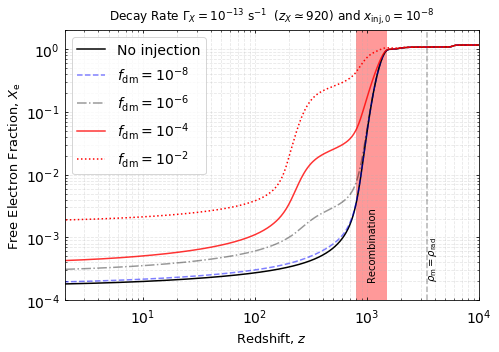

In [158]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 14
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['k','b','k','r','r'])
alphas = iter([1.,0.5,.4,0.8,1.])
lss = iter(['-','--','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter(['No injection',
               r'$f_\mathrm{dm}=10^{-8}$',
               r'$f_\mathrm{dm}=10^{-6}$',
               r'$f_\mathrm{dm}=10^{-4}$',
               r'$f_\mathrm{dm}=10^{-2}$'])


for i in range(len(p_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    param =p_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R[i]['z']
    xe = R[i]['Xe']
    
    ax.plot(z,xe,ls=next(lss),c=col,alpha = next(alphas),label=next(labels))#,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

# no injection case,alpha = next(alphas)
#z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
#Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

#f_no_inj = interp1d(z_no_inj,Xe_no_inj)
##Z_no_inj_new = np.logspace(-1,4,100)
#Xe_no_inj_new = f_no_inj(Z_no_inj_new)

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')

x_min = 2.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(1e3, 2e-4, 'Recombination', 
        color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



#ax.axvspan(3., 25, facecolor='red', alpha=0.2)
#ax.text(0.26, 0.05, 'Reionization', 
#        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
#        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(cosmo.z_eq()+50, 2e-4, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(8, 1.9e-4,  r'No injection', fontsize=10,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 4.5e-4,  r'$f_\mathrm{dm}=10^{-8}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#
#ax.text(8, 1.2e-3,  r'$f_\mathrm{dm}=10^{-6}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 8e-3,  r'$f_\mathrm{dm}=10^{-4}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 7e-2,  r'$f_\mathrm{dm}=10^{-2}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')




plt.title(r'Decay Rate $\Gamma_X=10^{-13}\,\,\mathrm{s}^{-1}$  ($z_X\simeq920$) and $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

ax.legend(loc=2,ncol=1,fontsize=14)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-13_fdm.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

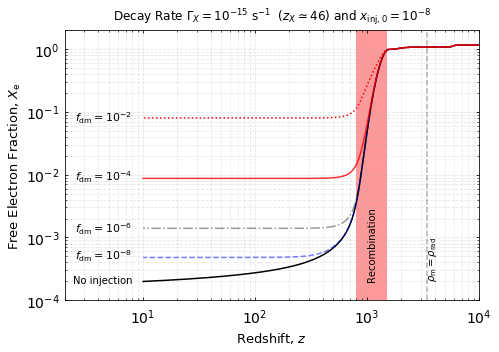

In [118]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 14
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['k','b','k','r','r'])
alphas = iter([1.,0.5,.4,0.8,1.])
lss = iter(['-','--','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


for i in range(len(p_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    param =p_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R[i]['z']
    xe = R[i]['Xe']
    
    ax.plot(z[z>10],xe[z>10],ls=next(lss),c=col,alpha = next(alphas))#,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

# no injection case,alpha = next(alphas)
#z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
#Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

#f_no_inj = interp1d(z_no_inj,Xe_no_inj)
##Z_no_inj_new = np.logspace(-1,4,100)
#Xe_no_inj_new = f_no_inj(Z_no_inj_new)

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')

x_min = 2.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(1e3, 2e-4, 'Recombination', 
        color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



#ax.axvspan(3., 25, facecolor='red', alpha=0.2)
#ax.text(0.26, 0.05, 'Reionization', 
#        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
#        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(cosmo.z_eq()+50, 2e-4, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


ax.text(8, 1.9e-4,  r'No injection', fontsize=10,color='k',
        rotation=0,horizontalalignment='right')
ax.text(8, 4.5e-4,  r'$f_\mathrm{dm}=10^{-8}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')

ax.text(8, 1.2e-3,  r'$f_\mathrm{dm}=10^{-6}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')
ax.text(8, 8e-3,  r'$f_\mathrm{dm}=10^{-4}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')
ax.text(8, 7e-2,  r'$f_\mathrm{dm}=10^{-2}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')




plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) and $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

#ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_fdm.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

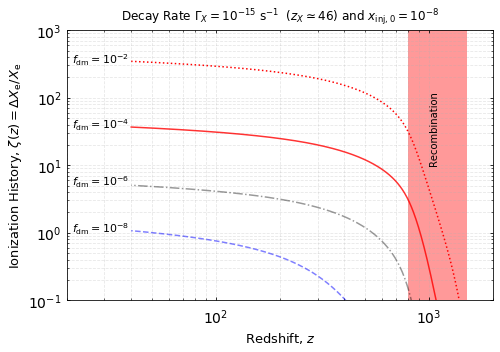

In [134]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 14
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['k','b','k','r','r'])
alphas = iter([1.,0.5,.4,0.8,1.])
lss = iter(['-','--','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


for i in range(len(p_array)):
    col = next(colors)
    ls = next(lss)
    alpha = next(alphas)
    if i == 0:
        continue
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    param =p_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R[i]['z']
    xe = (R[i]['Xe']-R[0]['Xe'])/R[0]['Xe']
    
    ax.plot(z[z>40],xe[z>40],ls=ls,c=col,alpha = alpha)#,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

# no injection case,alpha = next(alphas)
#z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
#Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

#f_no_inj = interp1d(z_no_inj,Xe_no_inj)
##Z_no_inj_new = np.logspace(-1,4,100)
#Xe_no_inj_new = f_no_inj(Z_no_inj_new)

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')

x_min = 20.
x_max = 2.e3

ymin = 1.e-1
ymax = 1e3

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_Zeta_e,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(1e3, 1e1, 'Recombination', 
        color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



#ax.axvspan(3., 25, facecolor='red', alpha=0.2)
#ax.text(0.26, 0.05, 'Reionization', 
#        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
#        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
#ax.text(cosmo.z_eq()+50, 2e-4, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
#        fontsize=10,
#        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.text(39, 1e0,  r'$f_\mathrm{dm}=10^{-8}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')

ax.text(39, 5,  r'$f_\mathrm{dm}=10^{-6}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')
ax.text(39, 35,  r'$f_\mathrm{dm}=10^{-4}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')
ax.text(39, 320,  r'$f_\mathrm{dm}=10^{-2}$', fontsize=11,color='k',
        rotation=0,horizontalalignment='right')



plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) and $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

#ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_DXe_Xe_fdm.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

# reionisation figure with recfast many lifetimes

In [359]:
rf.rf_xinj0 = 1e-8
rf.rf_f_dec = 1e-100
rf.rf_Gamma_dec = 1e-13

args = {}

p_name = 'Gamma_dec'
#p_name = 'f_dec'
p_array = [1e-11]
#p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R_no_injection = rf.run_recfast_parallel(**args)

In [360]:
#fdm = 1e-1
#fdm_array =  [1e-100,1e-8,1e-6,1e-4,1e-2]
#fdm =  1.3098e4*fdm/xdec

rf.rf_xinj0 = 1e-8
rf.rf_f_dec = 1e-6
rf.rf_Gamma_dec = 1e-13

args = {}

p_name = 'Gamma_dec'
#p_name = 'f_dec'
p_array = [1e-11,1e-13,1e-15,1e-17]
#p_array = fdm_array

args['param_values_array'] = p_array
args['param_name'] = p_name
args['save_recfast_results'] = 'no'
#rf.save_dir_name = 'case_' + '_xdec_' + str_dir
R = rf.run_recfast_parallel(**args)

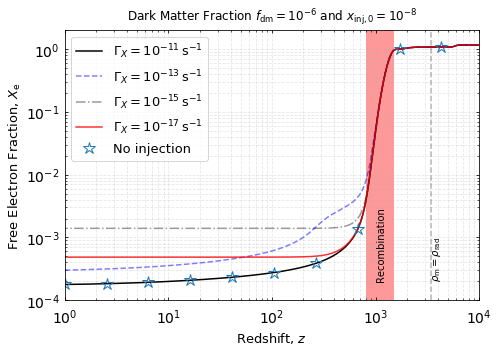

In [373]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 14
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['k','b','k','r','r'])
alphas = iter([1.,0.5,.4,0.8,1.])
lss = iter(['-','--','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([
               r'$\Gamma_X=10^{-11}\,\mathrm{s}^{-1}$',
               r'$\Gamma_X=10^{-13}\,\mathrm{s}^{-1}$',
               r'$\Gamma_X=10^{-15}\,\mathrm{s}^{-1}$',
               r'$\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$'])


for i in range(len(p_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    param =p_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R[i]['z']
    xe = R[i]['Xe']
    
    ax.plot(z,xe,ls=next(lss),c=col,alpha = next(alphas),label=next(labels))#,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

    

# no injection case,alpha = next(alphas)
#z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
#Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

#f_no_inj = interp1d(z_no_inj,Xe_no_inj)
##Z_no_inj_new = np.logspace(-1,4,100)
#Xe_no_inj_new = f_no_inj(Z_no_inj_new)

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')

x_min = 1.e0
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(1e3, 2e-4, 'Recombination', 
        color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



#ax.axvspan(3., 25, facecolor='red', alpha=0.2)
#ax.text(0.26, 0.05, 'Reionization', 
#        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
#        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(cosmo.z_eq()+50, 2e-4, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(8, 1.9e-4,  r'No injection', fontsize=10,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 4.5e-4,  r'$f_\mathrm{dm}=10^{-8}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#
#ax.text(8, 1.2e-3,  r'$f_\mathrm{dm}=10^{-6}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 8e-3,  r'$f_\mathrm{dm}=10^{-4}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')
#ax.text(8, 7e-2,  r'$f_\mathrm{dm}=10^{-2}$', fontsize=11,color='k',
#        rotation=0,horizontalalignment='right')


zni  = R_no_injection[0]['z']
xeni = R_no_injection[0]['Xe']
fxeni  = interp1d(zni,xeni,bounds_error=False, fill_value=0.)
zni_new = np.logspace(0,4,100)
xeni_new = fxeni(zni_new)
ax.plot(zni_new,xeni_new,ls='None',marker='*',markersize=12,markevery=10,markerfacecolor='None',
        label='No injection')

plt.title(r'Dark Matter Fraction $f_\mathrm{dm}=10^{-6}$ and $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

ax.legend(loc=2,ncol=1,fontsize=13)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_many_G_fdm_1e-6.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

# modes for PCA

In [84]:
pca_modes = sd.Xe_PCA_EigenModes()

In [85]:
pca_modes.Xe_PCA_EigenModes

{'E1': {'z': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.9998e+03, 3.9999e+03,
         4.0000e+03]),
  'values': array([ 6.70558e-05,  6.70781e-05,  6.71005e-05, ..., -1.08672e-07,
         -1.08551e-07, -1.08431e-07]),
  'sigma1': 0.12},
 'E2': {'z': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.9998e+03, 3.9999e+03,
         4.0000e+03]),
  'values': array([-4.47320e-05, -4.47469e-05, -4.47618e-05, ..., -5.33395e-07,
         -5.32803e-07, -5.32211e-07]),
  'sigma2': 0.19},
 'E3': {'z': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 3.9998e+03, 3.9999e+03,
         4.0000e+03]),
  'values': array([ 2.60501e-04,  2.60588e-04,  2.60675e-04, ..., -4.95191e-06,
         -4.94641e-06, -4.94092e-06]),
  'sigma3': 0.35}}

# Reionisation figures with cosmotherm

In [153]:
sd_lib_extended_run = pi.specdist_ct_spectra_lib()
case_id = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_190820'
pi.load_ct_spectra_lib(case_id,sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_with_collision_20x20_170820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_120820',sd_lib_extended_run)
#extended_run_xe_history_Drho_rho_5e-6_no_collision_160820
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_5e-6_no_collision_160820',sd_lib_extended_run)
#pi.load_ct_spectra_lib('extended_run_xe_history_Drho_rho_1e-8_160820',sd_lib_extended_run)
# sd_lib_xe_history_finj_fisher = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('xe_hi@story_200720_finj_fisher',sd_lib_xe_history_finj_fisher)
#sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
#pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [96]:
ct = pi.cosmotherm()
ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422
ct.ct_only_global_energetics = 1
ct.ct_pi_stim = 1
ct.ct_Gamma_dec = 1e-17
cosmo = pi.cosmo()
pi.set_cosmo_to_CT_cosmo_params(cosmo,ct)

## Critical behavior with collisions

## $\Gamma_X = 10^{-15}\mathrm{s}^{-1}$

In [131]:
gamma = 1e-15
# xinj values at low x, 1e-8, 1e-4

In [149]:
import specdist as sd
import numpy as np

photon_injection_case = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920'
compute_hubble_dist = 'no'

finj_from_fisher = 'no'
add_edges = 'yes'


if compute_hubble_dist == 'yes':
    Drho_rho = 1e-100
    photon_injection_case += '_hubble'
else:
    Drho_rho = 3e-5


# load photon injection and cosmotherm modules
ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()


if finj_from_fisher == 'yes' and compute_hubble_dist != 'yes':
    firas = sd.firas()
    edges = sd.edges()
    a_dict = {}
    a_dict['firas'] = firas
    a_dict['edges'] = edges
    a_dict['add_edges'] = 'yes'
    sd_lib_for_fisher = sd.specdist_ct_spectra_lib()
    sd.load_ct_spectra_lib("xe_history_200720",sd_lib_for_fisher)




# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

sd.set_dm_params_to_CT_pi_params(X_dm,ct)
sd.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),300)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),20)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1.e7),64)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#Gamma_X = 1e-6 #np.logspace(-9,-6,4)
#zi_array = [1.1e6,9.9e5]
#for Gamma_X in np.logspace(-30,-8,20):
#for Gamma_X in np.logspace(-8,-30,160)[0:80]:
for Gamma_X in [gamma]:
    str_gamma = str("%.3e"%Gamma_X)
    print(str_gamma)

    ct.ct_Gamma_dec = Gamma_X
    #ct.ct_x_dec = 1e7
    args = {}
    p_name = 'photon injection x_dec'
    #p_name = 'zend'
    p_array = xi_array
    #p_array = zi_array
    args['param_values_array'] = p_array
    args['param_name'] = p_name
    args['save_spectra'] = 'no'


    args['dict_for_fisher'] = {}
    args['sd_lib_for_fisher'] = None
    ct.ct_photon_injection_f_dec = 0.
    print('not using finj, using Drho_rho instead.')

    ct.ct_include_collisions = 0
    ct.ct_Drho_rho_dec = 3e-5
    R_no_collisions = ct.run_cosmotherm_parallel(**args)
    ct.ct_Drho_rho_dec = 1e-100
    R_no_collisions_no_injection = ct.run_cosmotherm_parallel(**args)
    
    ct.ct_include_collisions = 1
    ct.ct_Drho_rho_dec = 3e-5
    R_with_collisions = ct.run_cosmotherm_parallel(**args)
    ct.ct_Drho_rho_dec = 1e-100
    R_with_collisions_no_injection = ct.run_cosmotherm_parallel(**args)


    
    #print(R)


1.000e-15
not using finj, using Drho_rho instead.


In [133]:
pi.injection_redshift_zX(1e-15,cosmo,ct)

46.159796037378

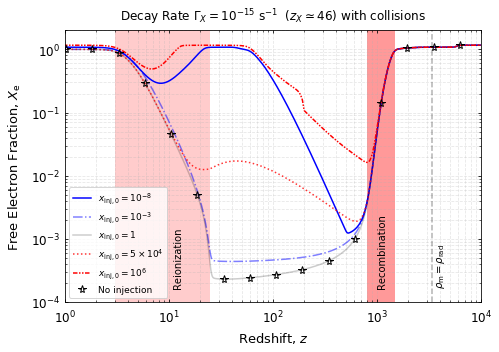

In [155]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    xinj =xi_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R_with_collisions[i]['Xe_redshifts']
    xe = R_with_collisions[i]['Xe_values']
    
    ax.plot(z,xe,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

# no injection case
z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.26, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) with collisions',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_collisions.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

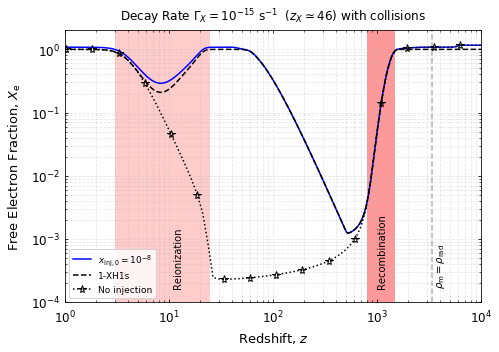

In [160]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


for i in range(len(xi_array)):
    if i>0:
        continue
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    xinj =xi_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R_with_collisions[i]['Xe_redshifts']
    xe = R_with_collisions[i]['Xe_values']
    
    ax.plot(z,xe,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    ax.plot(z,OnemXH1s,c='k',ls='--',label='1-XH1s')

# no injection case
z_no_inj = R_with_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = R_with_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls=':',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.26, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) with collisions',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_collisions_contributions.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

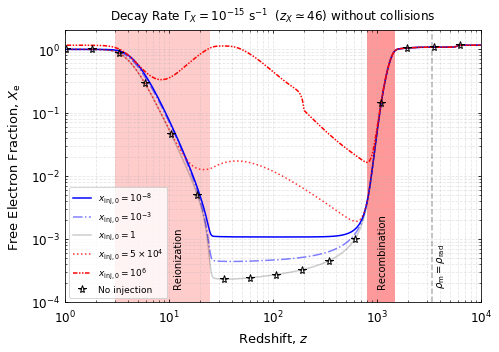

In [156]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
#xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])



for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = gi_array[i]
    xinj =xi_array[i]
    
    
    # compute from the library ? ---> uncomment there 
    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['Xe'])):
    #    print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    #ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
    #        alpha = next(alphas),
    #        label=next(labels))
    #        #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    
    z = R_no_collisions[i]['Xe_redshifts']
    xe = R_no_collisions[i]['Xe_values']
    
    ax.plot(z,xe,c=col,ls=next(lss),alpha = next(alphas),label=next(labels))
    #OnemXH1s = 1.-R_with_collisions[i]['Xe_values_X1s']
    #ax.plot(z,OnemXH1s,c='k',ls='--')

# no injection case
z_no_inj = R_no_collisions_no_injection[0]['Xe_redshifts']#sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = R_no_collisions_no_injection[0]['Xe_values']#sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.26, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) without collisions',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_no_collisions.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

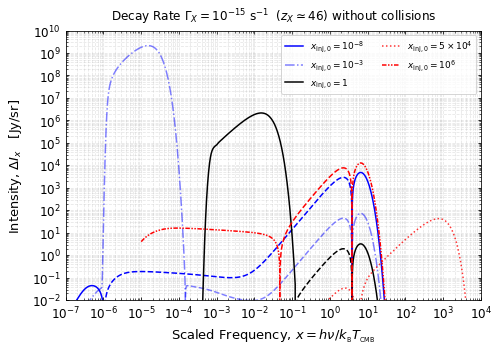

In [163]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5

x_min = 1.e-7
x_max = 1.e4

ymin = 1.e-2
ymax = 1e10

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)
ax.xaxis.set_label_coords(0.5,-.1)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





x_asked = np.logspace(np.log10(1e-8),np.log10(1e7),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,1.,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = 1e-13
    #gamma = gi_array[i]
    xinj =xi_array[i]
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run)

    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['DI'])):
    #   print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ls = next(lss)
    alpha = next(alphas)
    ax.plot(R_no_collisions[i]['x'],R_no_collisions[i]['DI']-R_no_collisions_no_injection[i]['DI'],c=col,ls=ls,
            alpha = alpha,
            label = next(labels))
    ax.plot(R_no_collisions[i]['x'],-(R_no_collisions[i]['DI']-R_no_collisions_no_injection[i]['DI']),c=col,ls='--',
        alpha = alpha)
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')




#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)





#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.legend(loc=1,ncol=2,fontsize=9)

#ax.loglog()

plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) without collisions',pad=10.)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_DI_G_1e-15_without_collisions.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

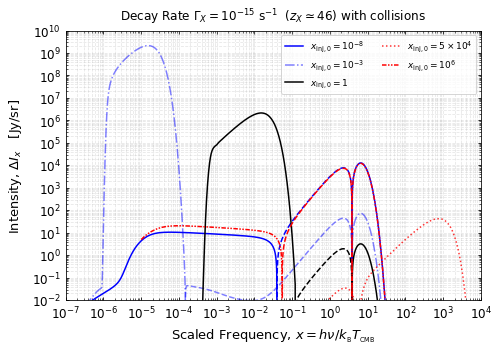

In [164]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5

x_min = 1.e-7
x_max = 1.e4

ymin = 1.e-2
ymax = 1e10

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)
ax.xaxis.set_label_coords(0.5,-.1)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





x_asked = np.logspace(np.log10(1e-8),np.log10(1e7),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,1.,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    #gamma = 1e-13
    #gamma = gi_array[i]
    xinj =xi_array[i]
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run)

    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    #if np.isnan(np.sum(S_xe_history['DI'])):
    #   print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ls = next(lss)
    alpha = next(alphas)
    ax.plot(R_with_collisions[i]['x'],R_with_collisions[i]['DI']-R_with_collisions_no_injection[i]['DI'],c=col,ls=ls,
            alpha = alpha,
            label = next(labels))
    ax.plot(R_with_collisions[i]['x'],-(R_with_collisions[i]['DI']-R_with_collisions_no_injection[i]['DI']),c=col,ls='--',
        alpha = alpha)
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')




#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)





#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.legend(loc=1,ncol=2,fontsize=9)

#ax.loglog()

plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$) with collisions',pad=10.)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_DI_G_1e-15_with_collisions.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

# Spectra vs Xe histories --> see slides

### $\Gamma_X = 10^{-13}\,\,\mathrm{s}^{-1}$

In [165]:
pi.injection_redshift_zX(1e-13,cosmo,ct)

917.4914779746255

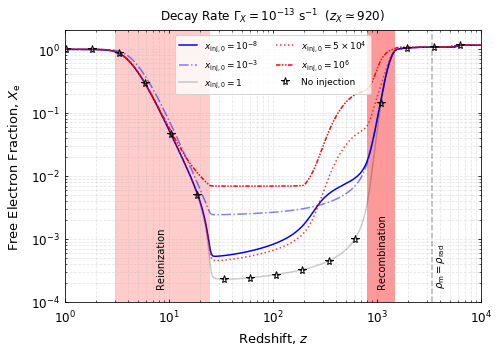

In [193]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-13
    #gamma = gi_array[i]
    xinj =xi_array[i]
    S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['Xe'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
            alpha = next(alphas),
            label=next(labels))
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    

    
z_no_inj = sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.22, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-13}\,\,\mathrm{s}^{-1}$  ($z_X\simeq920$)',pad=10.)

ax.legend(loc='upper center',ncol=2,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-13.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

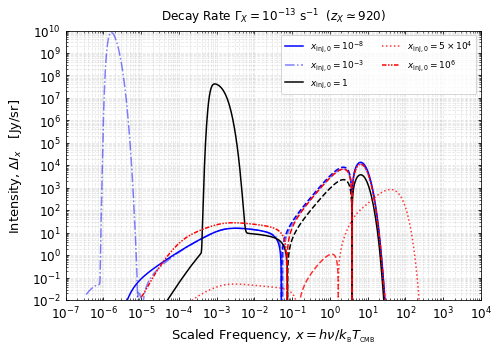

In [199]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5

x_min = 1.e-7
x_max = 1.e4

ymin = 1.e-2
ymax = 1e10

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)
ax.xaxis.set_label_coords(0.5,-.1)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





x_asked = np.logspace(np.log10(1e-8),np.log10(1e7),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,1.,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-13
    #gamma = gi_array[i]
    xinj =xi_array[i]
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run)

    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['DI'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ls = next(lss)
    alpha = next(alphas)
    ax.plot(S_xe_history['x'],S_xe_history['DI'],c=col,ls=ls,
            alpha = alpha,
            label = next(labels))
    ax.plot(S_xe_history['x'],-S_xe_history['DI'],c=col,ls='--',
        alpha = alpha)
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')




#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)





#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.legend(loc=1,ncol=2,fontsize=9)

#ax.loglog()

plt.title(r'Decay Rate $\Gamma_X=10^{-13}\,\,\mathrm{s}^{-1}$  ($z_X\simeq920$)',pad=10.)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_DI_G_1e-13.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

## $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$

In [195]:
pi.injection_redshift_zX(1e-15,cosmo,ct)

46.159796037378

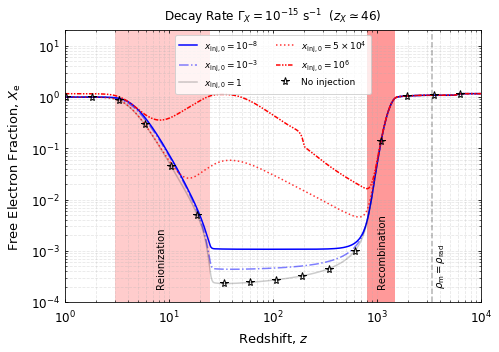

In [197]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-15
    #gamma = gi_array[i]
    xinj =xi_array[i]
    S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['Xe'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
            alpha = next(alphas),
            label=next(labels))
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    

    
z_no_inj = sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e1

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.22, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$)',pad=10.)

ax.legend(loc='upper center',ncol=2,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

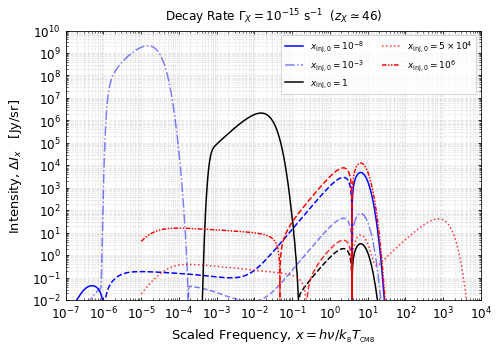

In [198]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5

x_min = 1.e-7
x_max = 1.e4

ymin = 1.e-2
ymax = 1e10

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)
ax.xaxis.set_label_coords(0.5,-.1)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





x_asked = np.logspace(np.log10(1e-8),np.log10(1e7),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,1.,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-15
    #gamma = gi_array[i]
    xinj =xi_array[i]
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run)

    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['DI'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ls = next(lss)
    alpha = next(alphas)
    ax.plot(S_xe_history['x'],S_xe_history['DI'],c=col,ls=ls,
            alpha = alpha,
            label = next(labels))
    ax.plot(S_xe_history['x'],-S_xe_history['DI'],c=col,ls='--',
        alpha = alpha)
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')




#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)





#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.legend(loc=1,ncol=2,fontsize=9)

#ax.loglog()

plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$)',pad=10.)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_DI_G_1e-15.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

## $\Gamma_X=10^{-17}\,\,\mathrm{s}^{-1}$

In [200]:
pi.injection_redshift_zX(1e-17,cosmo,ct)

1.2233237229844878

nan for xinj=1.0000e+06 and Gamma=1.0000e-17


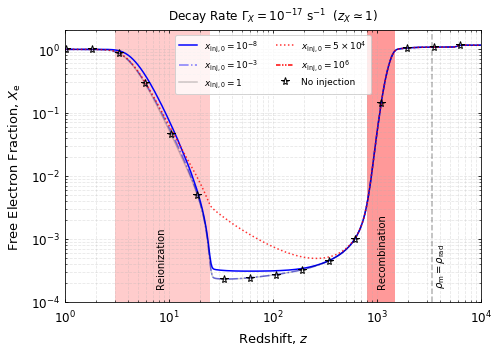

In [203]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-17
    #gamma = gi_array[i]
    xinj =xi_array[i]
    S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['Xe'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ax.plot(S_xe_history['z'],np.abs(S_xe_history['Xe']),c=col,ls=next(lss),
            alpha = next(alphas),
            label=next(labels))
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))
    

    
z_no_inj = sd_lib_extended_run.Xe_redshifts_no_inj_2d[0][0]
Xe_no_inj = sd_lib_extended_run.Xe_values_no_inj_2d[0][0]

f_no_inj = interp1d(z_no_inj,Xe_no_inj)
Z_no_inj_new = np.logspace(-1,4,100)
Xe_no_inj_new = f_no_inj(Z_no_inj_new)

ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
       markerfacecolor='None',label='No injection')

x_min = 1.
x_max = 1.e4

ymin = 1.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 1500, facecolor='red', alpha=0.4)
ax.text(0.75, 0.05, 'Recombination', 
        transform=ax.transAxes,color='k',
        rotation=90,fontsize=10,verticalalignment='bottom')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(0.22, 0.05, 'Reionization', 
        transform=ax.transAxes,color='k',rotation=90,fontsize=10,
        verticalalignment='bottom')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')




#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)


plt.title(r'Decay Rate $\Gamma_X=10^{-17}\,\,\mathrm{s}^{-1}$  ($z_X\simeq1$)',pad=10.)

ax.legend(loc='upper center',ncol=2,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-17.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

nan for xinj=1.0000e+06 and Gamma=1.0000e-17


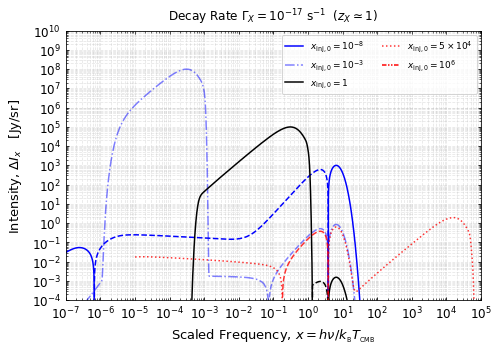

In [208]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5

x_min = 1.e-7
x_max = 1.e5

ymin = 1.e-4
ymax = 1e10

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_ylabel(label_intensity,size=title_size)
ax.set_xlabel(label_scaled_frequency,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)
ax.xaxis.set_label_coords(0.5,-.1)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

# manipulate x-axis ticks and labels
#ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
#ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(True)


locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=5000)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1,numticks=500)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(True)





ax.grid( b=True, which="both", alpha=0.3, linestyle='--')





x_asked = np.logspace(np.log10(1e-8),np.log10(1e7),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,1.,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])
for i in range(len(xi_array)):
    col = next(colors)
    #plt.plot(R[i]['z'],R[i]['Xe'],c=col)
    #plt.plot(R_no_inj[i]['z'],R_no_inj[i]['Xe'],ls='--',c=col)
    #gamma = R[i]['Gamma_dec']
    gamma = 1e-17
    #gamma = gi_array[i]
    xinj =xi_array[i]
    #S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run,get_fisher_fdm='yes')
    S_xe_history = sd.GetSpectra(gamma,xinj,x_asked,sd_lib_extended_run)

    #S_xe_history = pi.GetXeHistory(gamma,xinj,z_asked,sd_lib_extended_run)
    if np.isnan(np.sum(S_xe_history['DI'])):
        print('nan for xinj=%.4e and Gamma=%.4e'%(xinj,gamma))
    ls = next(lss)
    alpha = next(alphas)
    ax.plot(S_xe_history['x'],S_xe_history['DI'],c=col,ls=ls,
            alpha = alpha,
            label = next(labels))
    ax.plot(S_xe_history['x'],-S_xe_history['DI'],c=col,ls='--',
        alpha = alpha)
            #label=r'$x_\mathrm{inj,0}=$'+scientific_notation(xinj))

#ax.plot(Z_no_inj_new,Xe_no_inj_new,ls='None',c='k',marker='*',markersize=8,markevery=5,
#       markerfacecolor='None',label='No injection')




#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)





#ax.text(0.29, 0.03, r'standard case with $\Gamma_X=10^{-17}\,\mathrm{s}^{-1}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=-75)

#ax.text(0.01, 0.67, r'$x_\mathrm{inj,0} = 10$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=30)


#ax.text(0.32, 0.72,  r'$x_\mathrm{inj,0} = 1$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=45)

#ax.text(0.655, 0.671,  r'$x_\mathrm{inj,0} = 10^{-2}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=73)


#ax.text(0.885, 0.71,  r'$x_\mathrm{inj,0} = 10^{-4}$', fontsize=7,transform=ax.transAxes,color='k',
#        rotation=78)



ax.legend(loc=1,ncol=2,fontsize=9)

#ax.loglog()

plt.title(r'Decay Rate $\Gamma_X=10^{-17}\,\,\mathrm{s}^{-1}$  ($z_X\simeq1$)',pad=10.)
fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_DI_G_1e-17.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

## Disentangling the different contributions to ionisation history

(rescomputing cases, as we dont save He info in the library)

In [52]:
gamma = 1e-15
xinj = 1e6

In [53]:
import specdist as sd
import numpy as np

photon_injection_case = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920'
compute_hubble_dist = 'no'

finj_from_fisher = 'no'
add_edges = 'yes'


if compute_hubble_dist == 'yes':
    Drho_rho = 1e-100
    photon_injection_case += '_hubble'
else:
    Drho_rho = 3e-5


# load photon injection and cosmotherm modules
ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()


if finj_from_fisher == 'yes' and compute_hubble_dist != 'yes':
    firas = sd.firas()
    edges = sd.edges()
    a_dict = {}
    a_dict['firas'] = firas
    a_dict['edges'] = edges
    a_dict['add_edges'] = 'yes'
    sd_lib_for_fisher = sd.specdist_ct_spectra_lib()
    sd.load_ct_spectra_lib("xe_history_200720",sd_lib_for_fisher)




# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

sd.set_dm_params_to_CT_pi_params(X_dm,ct)
sd.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),300)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),20)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1.e7),64)
xi_array = [xinj]
#Gamma_X = 1e-6 #np.logspace(-9,-6,4)
#zi_array = [1.1e6,9.9e5]
#for Gamma_X in np.logspace(-30,-8,20):
#for Gamma_X in np.logspace(-8,-30,160)[0:80]:
for Gamma_X in [gamma]:
    str_gamma = str("%.3e"%Gamma_X)
    print(str_gamma)

    ct.ct_Gamma_dec = Gamma_X
    #ct.ct_x_dec = 1e7
    args = {}
    p_name = 'photon injection x_dec'
    #p_name = 'zend'
    p_array = xi_array
    #p_array = zi_array
    args['param_values_array'] = p_array
    args['param_name'] = p_name
    args['save_spectra'] = 'no'


    args['dict_for_fisher'] = {}
    args['sd_lib_for_fisher'] = None
    ct.ct_photon_injection_f_dec = 0.
    print('not using finj, using Drho_rho instead.')




    #ct.save_dir_name = photon_injection_case + '_G_' + str_gamma

    R = ct.run_cosmotherm_parallel(**args)
#print(R)


1.000e-15
not using finj, using Drho_rho instead.


In [54]:
pi.injection_redshift_zX(1e-15,cosmo,ct)

46.159796037378

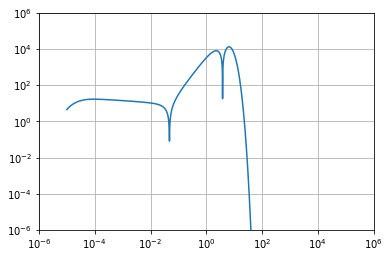

In [55]:
plt.plot(R[0]['x'],abs(R[0]['DI']))
plt.loglog()
plt.xlim(1e-6,1e6)
plt.ylim(1e-6,1e6)
plt.grid(which='both')

In [30]:
Ypv = 0.245407
const_mHe4_mH = 3.97152594    
fac_mHemH=const_mHe4_mH/4.0
fHe = Ypv/(4.0*fac_mHemH)/(1.0-Ypv)
fHe

0.08188734130178943

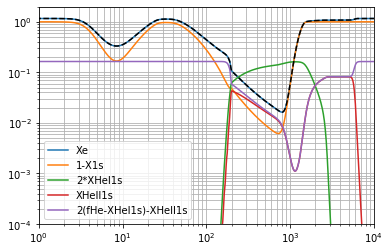

In [56]:
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],label='Xe')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],label='1-X1s')
plt.plot(R[0]['Xe_redshifts'],2*R[0]['Xe_values_XHeI1s'],label='2*XHeI1s')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],label='XHeII1s')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],label='2(fHe-XHeI1s)-XHeII1s')

plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         c='k',ls='--')
#plt.plot(R[0]['Xe_redshifts'],2*abs((fHe-R[0]['Xe_values_XHeI1s']-R[0]['Xe_values_XHeII1s'])),label='2(fHe-XHeI1s-XHeII1s')


plt.loglog()
plt.xlim(1e0,1e4)
plt.ylim(1e-4,2e0)
plt.legend()
plt.grid(which='both')
plt.savefig(path_to_figures + '/figures_for_paper_all_contib_to_Xe_xinj_1e6.pdf')

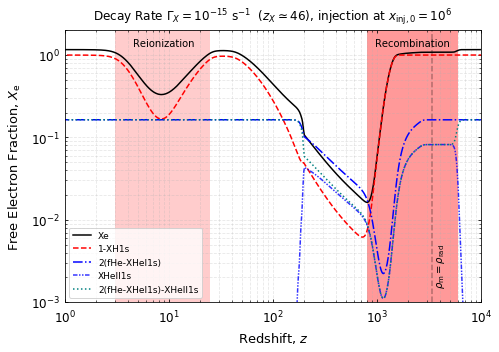

In [106]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


x_min = 1.
x_max = 1.e4

ymin = 1.e-3
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 6000, facecolor='red', alpha=0.4)
ax.text(2.2e3, 1.4, 'Recombination', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(9., 1.4, 'Reionization', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')

plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],
         label='Xe',c='k',ls='-')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],
         label='1-XH1s',c='r',alpha=1,ls='--')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s']),
         label='2(fHe-XHeI1s)',ls='-.',c='b')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],
         label='XHeII1s',ls=(0, (3, 1, 1, 1, 1, 1)),alpha=0.8,c='b')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         label='2(fHe-XHeI1s)-XHeII1s',ls=':',c='teal')

#plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
 #        c='k',ls='--')



plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$), injection at $x_\mathrm{inj,0}=10^{6}$',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_xinj_1e6.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

In [107]:
gamma = 1e-15
xinj = 5e4

In [108]:
import specdist as sd
import numpy as np

photon_injection_case = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920'
compute_hubble_dist = 'no'

finj_from_fisher = 'no'
add_edges = 'yes'


if compute_hubble_dist == 'yes':
    Drho_rho = 1e-100
    photon_injection_case += '_hubble'
else:
    Drho_rho = 3e-5


# load photon injection and cosmotherm modules
ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()


if finj_from_fisher == 'yes' and compute_hubble_dist != 'yes':
    firas = sd.firas()
    edges = sd.edges()
    a_dict = {}
    a_dict['firas'] = firas
    a_dict['edges'] = edges
    a_dict['add_edges'] = 'yes'
    sd_lib_for_fisher = sd.specdist_ct_spectra_lib()
    sd.load_ct_spectra_lib("xe_history_200720",sd_lib_for_fisher)




# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

sd.set_dm_params_to_CT_pi_params(X_dm,ct)
sd.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),300)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),20)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1.e7),64)
xi_array = [xinj]
#Gamma_X = 1e-6 #np.logspace(-9,-6,4)
#zi_array = [1.1e6,9.9e5]
#for Gamma_X in np.logspace(-30,-8,20):
#for Gamma_X in np.logspace(-8,-30,160)[0:80]:
for Gamma_X in [gamma]:
    str_gamma = str("%.3e"%Gamma_X)
    print(str_gamma)

    ct.ct_Gamma_dec = Gamma_X
    #ct.ct_x_dec = 1e7
    args = {}
    p_name = 'photon injection x_dec'
    #p_name = 'zend'
    p_array = xi_array
    #p_array = zi_array
    args['param_values_array'] = p_array
    args['param_name'] = p_name
    args['save_spectra'] = 'no'


    args['dict_for_fisher'] = {}
    args['sd_lib_for_fisher'] = None
    ct.ct_photon_injection_f_dec = 0.
    print('not using finj, using Drho_rho instead.')




    #ct.save_dir_name = photon_injection_case + '_G_' + str_gamma

    R = ct.run_cosmotherm_parallel(**args)
#print(R)


1.000e-15
not using finj, using Drho_rho instead.


In [109]:
pi.injection_redshift_zX(1e-15,cosmo,ct)

46.159796037378

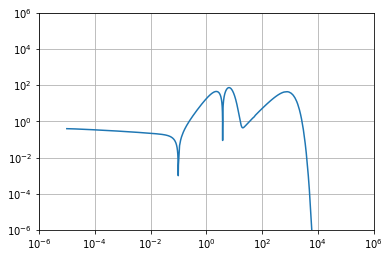

In [110]:
plt.plot(R[0]['x'],abs(R[0]['DI']))
plt.loglog()
plt.xlim(1e-6,1e6)
plt.ylim(1e-6,1e6)
plt.grid(which='both')

In [111]:
Ypv = 0.245407
const_mHe4_mH = 3.97152594    
fac_mHemH=const_mHe4_mH/4.0
fHe = Ypv/(4.0*fac_mHemH)/(1.0-Ypv)
fHe

0.08188734130178943

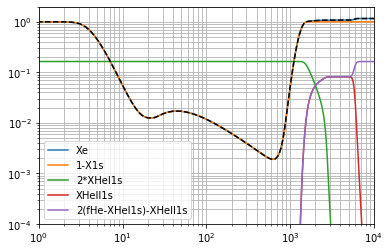

In [112]:
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],label='Xe')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],label='1-X1s')
plt.plot(R[0]['Xe_redshifts'],2*R[0]['Xe_values_XHeI1s'],label='2*XHeI1s')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],label='XHeII1s')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],label='2(fHe-XHeI1s)-XHeII1s')

plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         c='k',ls='--')
#plt.plot(R[0]['Xe_redshifts'],2*abs((fHe-R[0]['Xe_values_XHeI1s']-R[0]['Xe_values_XHeII1s'])),label='2(fHe-XHeI1s-XHeII1s')


plt.loglog()
plt.xlim(1e0,1e4)
plt.ylim(1e-4,2e0)
plt.legend()
plt.grid(which='both')
plt.savefig(path_to_figures + '/figures_for_paper_all_contib_to_Xe_xinj_1e6.pdf')

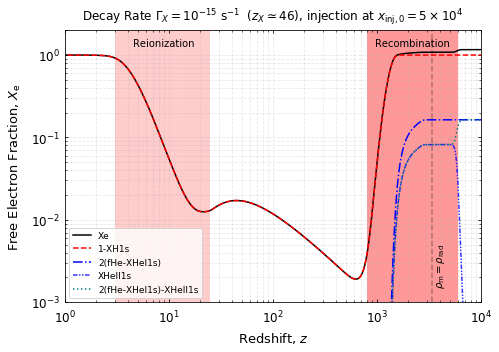

In [113]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


x_min = 1.
x_max = 1.e4

ymin = 1.e-3
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 6000, facecolor='red', alpha=0.4)
ax.text(2.2e3, 1.4, 'Recombination', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(9., 1.4, 'Reionization', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')

plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],
         label='Xe',c='k',ls='-')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],
         label='1-XH1s',c='r',alpha=1,ls='--')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s']),
         label='2(fHe-XHeI1s)',ls='-.',c='b')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],
         label='XHeII1s',ls=(0, (3, 1, 1, 1, 1, 1)),alpha=0.8,c='b')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         label='2(fHe-XHeI1s)-XHeII1s',ls=':',c='teal')

#plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
 #        c='k',ls='--')



plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$), injection at $x_\mathrm{inj,0}=5\times 10^{4}$',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_xinj_5e4.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

In [115]:
gamma = 1e-15
xinj = 1e-8

In [116]:
import specdist as sd
import numpy as np

photon_injection_case = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920'
compute_hubble_dist = 'no'

finj_from_fisher = 'no'
add_edges = 'yes'


if compute_hubble_dist == 'yes':
    Drho_rho = 1e-100
    photon_injection_case += '_hubble'
else:
    Drho_rho = 3e-5


# load photon injection and cosmotherm modules
ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()


if finj_from_fisher == 'yes' and compute_hubble_dist != 'yes':
    firas = sd.firas()
    edges = sd.edges()
    a_dict = {}
    a_dict['firas'] = firas
    a_dict['edges'] = edges
    a_dict['add_edges'] = 'yes'
    sd_lib_for_fisher = sd.specdist_ct_spectra_lib()
    sd.load_ct_spectra_lib("xe_history_200720",sd_lib_for_fisher)




# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

sd.set_dm_params_to_CT_pi_params(X_dm,ct)
sd.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),300)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),20)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1.e7),64)
xi_array = [xinj]
#Gamma_X = 1e-6 #np.logspace(-9,-6,4)
#zi_array = [1.1e6,9.9e5]
#for Gamma_X in np.logspace(-30,-8,20):
#for Gamma_X in np.logspace(-8,-30,160)[0:80]:
for Gamma_X in [gamma]:
    str_gamma = str("%.3e"%Gamma_X)
    print(str_gamma)

    ct.ct_Gamma_dec = Gamma_X
    #ct.ct_x_dec = 1e7
    args = {}
    p_name = 'photon injection x_dec'
    #p_name = 'zend'
    p_array = xi_array
    #p_array = zi_array
    args['param_values_array'] = p_array
    args['param_name'] = p_name
    args['save_spectra'] = 'no'


    args['dict_for_fisher'] = {}
    args['sd_lib_for_fisher'] = None
    ct.ct_photon_injection_f_dec = 0.
    print('not using finj, using Drho_rho instead.')




    #ct.save_dir_name = photon_injection_case + '_G_' + str_gamma

    R = ct.run_cosmotherm_parallel(**args)
#print(R)


1.000e-15
not using finj, using Drho_rho instead.


In [117]:
pi.injection_redshift_zX(1e-15,cosmo,ct)

46.159796037378

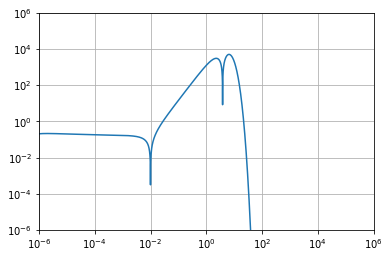

In [118]:
plt.plot(R[0]['x'],abs(R[0]['DI']))
plt.loglog()
plt.xlim(1e-6,1e6)
plt.ylim(1e-6,1e6)
plt.grid(which='both')

In [119]:
Ypv = 0.245407
const_mHe4_mH = 3.97152594    
fac_mHemH=const_mHe4_mH/4.0
fHe = Ypv/(4.0*fac_mHemH)/(1.0-Ypv)
fHe

0.08188734130178943

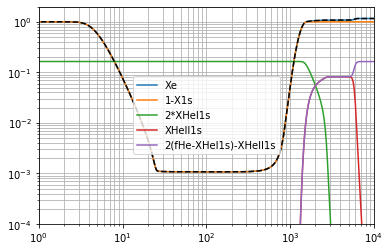

In [120]:
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],label='Xe')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],label='1-X1s')
plt.plot(R[0]['Xe_redshifts'],2*R[0]['Xe_values_XHeI1s'],label='2*XHeI1s')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],label='XHeII1s')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],label='2(fHe-XHeI1s)-XHeII1s')

plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         c='k',ls='--')
#plt.plot(R[0]['Xe_redshifts'],2*abs((fHe-R[0]['Xe_values_XHeI1s']-R[0]['Xe_values_XHeII1s'])),label='2(fHe-XHeI1s-XHeII1s')


plt.loglog()
plt.xlim(1e0,1e4)
plt.ylim(1e-4,2e0)
plt.legend()
plt.grid(which='both')
#plt.savefig(path_to_figures + '/figures_for_paper_all_contib_to_Xe_xinj_1e6.pdf')

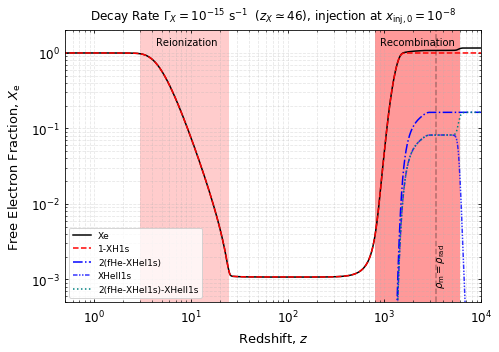

In [123]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


x_min = 5.e-1
x_max = 1.e4

ymin = 5.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 6000, facecolor='red', alpha=0.4)
ax.text(2.2e3, 1.4, 'Recombination', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(9., 1.4, 'Reionization', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')

plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],
         label='Xe',c='k',ls='-')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],
         label='1-XH1s',c='r',alpha=1,ls='--')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s']),
         label='2(fHe-XHeI1s)',ls='-.',c='b')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],
         label='XHeII1s',ls=(0, (3, 1, 1, 1, 1, 1)),alpha=0.8,c='b')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         label='2(fHe-XHeI1s)-XHeII1s',ls=':',c='teal')

#plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
 #        c='k',ls='--')



plt.title(r'Decay Rate $\Gamma_X=10^{-15}\,\,\mathrm{s}^{-1}$  ($z_X\simeq46$), injection at $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-15_xinj_1e-8.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

In [124]:
gamma = 1e-13
xinj = 1e-8

In [125]:
import specdist as sd
import numpy as np

photon_injection_case = 'extended_run_xe_history_Drho_rho_3e-5_zlate_1e3_without_collision_stim_070920'
compute_hubble_dist = 'no'

finj_from_fisher = 'no'
add_edges = 'yes'


if compute_hubble_dist == 'yes':
    Drho_rho = 1e-100
    photon_injection_case += '_hubble'
else:
    Drho_rho = 3e-5


# load photon injection and cosmotherm modules
ct = sd.cosmotherm()
cosmo = sd.cosmo()
X_dm = sd.dm_particle()


if finj_from_fisher == 'yes' and compute_hubble_dist != 'yes':
    firas = sd.firas()
    edges = sd.edges()
    a_dict = {}
    a_dict['firas'] = firas
    a_dict['edges'] = edges
    a_dict['add_edges'] = 'yes'
    sd_lib_for_fisher = sd.specdist_ct_spectra_lib()
    sd.load_ct_spectra_lib("xe_history_200720",sd_lib_for_fisher)




# set relevant parameter values
ct.ct_Drho_rho_dec = Drho_rho
# ct.ct_h = 0.70
# ct.ct_Omega_b = 0.0457
# ct.ct_Omega_m = 0.30
ct.ct_emission_absorption_mode = 0
ct.ct_npts = 3000
#ct.ct_zend = 4e6
# ct.ct_zstart = 5e6
ct.ct_zend = 1e-2
ct.ct_zstart = 5e6
ct.ct_zlate = 1e3

ct.ct_T0 = 2.7255
ct.ct_Yp = 0.245407
ct.ct_N_eff = 3.046
ct.ct_Omega_m = 0.312331
ct.ct_Omega_b = 0.0491137
ct.ct_h = 0.675422

ct.ct_include_pi = 1
ct.ct_evolve_Xe = 1
ct.save_Xe = 'yes'
ct.ct_lyc = 1
ct.ct_pi_stim = 0
ct.ct_pi_energy_norm = 0
ct.ct_reionisation_model = 1

ct.ct_include_collisions = 0

sd.set_dm_params_to_CT_pi_params(X_dm,ct)
sd.set_cosmo_to_CT_cosmo_params(cosmo,ct)

#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),300)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1e7),20)
#xi_array = np.logspace(np.log10(1e-8),np.log10(1.e7),64)
xi_array = [xinj]
#Gamma_X = 1e-6 #np.logspace(-9,-6,4)
#zi_array = [1.1e6,9.9e5]
#for Gamma_X in np.logspace(-30,-8,20):
#for Gamma_X in np.logspace(-8,-30,160)[0:80]:
for Gamma_X in [gamma]:
    str_gamma = str("%.3e"%Gamma_X)
    print(str_gamma)

    ct.ct_Gamma_dec = Gamma_X
    #ct.ct_x_dec = 1e7
    args = {}
    p_name = 'photon injection x_dec'
    #p_name = 'zend'
    p_array = xi_array
    #p_array = zi_array
    args['param_values_array'] = p_array
    args['param_name'] = p_name
    args['save_spectra'] = 'no'


    args['dict_for_fisher'] = {}
    args['sd_lib_for_fisher'] = None
    ct.ct_photon_injection_f_dec = 0.
    print('not using finj, using Drho_rho instead.')




    #ct.save_dir_name = photon_injection_case + '_G_' + str_gamma

    R = ct.run_cosmotherm_parallel(**args)
#print(R)


1.000e-13
not using finj, using Drho_rho instead.


In [126]:
pi.injection_redshift_zX(1e-13,cosmo,ct)

917.4914779746255

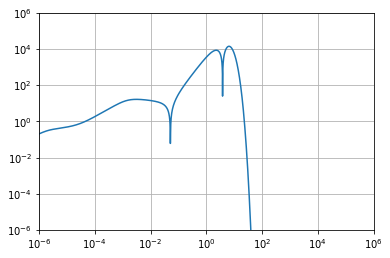

In [127]:
plt.plot(R[0]['x'],abs(R[0]['DI']))
plt.loglog()
plt.xlim(1e-6,1e6)
plt.ylim(1e-6,1e6)
plt.grid(which='both')

In [128]:
Ypv = 0.245407
const_mHe4_mH = 3.97152594    
fac_mHemH=const_mHe4_mH/4.0
fHe = Ypv/(4.0*fac_mHemH)/(1.0-Ypv)
fHe

0.08188734130178943

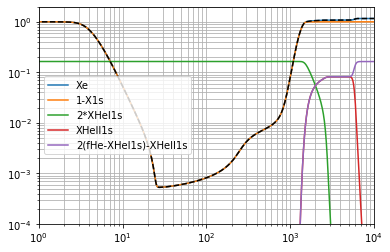

In [129]:
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],label='Xe')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],label='1-X1s')
plt.plot(R[0]['Xe_redshifts'],2*R[0]['Xe_values_XHeI1s'],label='2*XHeI1s')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],label='XHeII1s')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],label='2(fHe-XHeI1s)-XHeII1s')

plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         c='k',ls='--')
#plt.plot(R[0]['Xe_redshifts'],2*abs((fHe-R[0]['Xe_values_XHeI1s']-R[0]['Xe_values_XHeII1s'])),label='2(fHe-XHeI1s-XHeII1s')


plt.loglog()
plt.xlim(1e0,1e4)
plt.ylim(1e-4,2e0)
plt.legend()
plt.grid(which='both')
#plt.savefig(path_to_figures + '/figures_for_paper_all_contib_to_Xe_xinj_1e6.pdf')

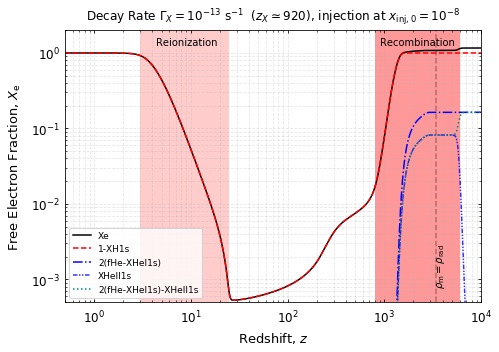

In [130]:
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, ax = plt.subplots(1,1,figsize=(7,5))
label_size = 12
title_size = 13
legend_size = 25
handle_length = 1.5


z_asked = np.logspace(np.log10(1e-2),np.log10(60000),5000)
xdec = 1e-6
#gi_array = np.logspace(np.log10(1e-17),np.log10(1e-8),5)
#xi_array = np.logspace(-8,7,10)
xi_array = [1e-8,1e-3,1,5e4,1e6]
#colors = iter(['purple','blue','green','pink','orange','red','magenta'])
colors = iter(['b','b','k','r','r'])
alphas = iter([1.,0.5,.2,0.8,1.])
lss = iter(['-','-.','-',':',(0, (3, 1, 1, 1, 1, 1))])
labels = iter([r'$x_\mathrm{inj,0}=10^{-8}$',r'$x_\mathrm{inj,0}=10^{-3}$',r'$x_\mathrm{inj,0}=1$',r'$x_\mathrm{inj,0}=5\times10^{4}$',r'$x_\mathrm{inj,0}=10^{6}$'])


x_min = 5.e-1
x_max = 1.e4

ymin = 5.e-4
ymax = 2e0

ax.set_xlim(x_min,x_max)
ax.set_ylim(ymin,ymax)
ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel("Redshift, "+ r'$z$',size=title_size)
ax.set_ylabel(label_xe,size=title_size)
#ax.set_ylabel(r"Particle Decay History, $N_X(z)/N_X(z_\mathrm{ini})$",size=title_size)

ax.yaxis.set_label_coords(-.1,0.5)

ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=7)

plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=1000))
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
                                      numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.grid( b=True, which="both", alpha=0.3, linestyle='--')


ax.axvspan(800., 6000, facecolor='red', alpha=0.4)
ax.text(2.2e3, 1.4, 'Recombination', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')

ax.axvspan(3.e5, x_max, facecolor='orange', alpha=0.6)
#ax.text(0.9, 1.02, r'$\mu$ era', fontsize=9,
#        transform=ax.transAxes,color='k',rotation=0)

ax.axvspan(5e4, 3e5, facecolor='orange', alpha=0.4)
#ax.text(0.72, 1.02, r'$\mu$-$y$ transition', fontsize=9,transform=ax.transAxes,color='k',
#        rotation=0)

#ax.axvspan(x_min, 5e4, facecolor='orange', alpha=0.2)
#ax.text(0.4, 1.02, r'$y$ era', fontsize=9, transform=ax.transAxes,color='k',rotation=0)



ax.axvspan(3., 25, facecolor='red', alpha=0.2)
ax.text(9., 1.4, 'Reionization', 
        #transform=ax.transAxes,
        color='k',rotation=0,fontsize=10,
        verticalalignment='center',
        horizontalalignment='center')



#color=iter(cm.viridis(np.linspace(0.7,0.,nxinj)))


ax.axvline(cosmo.z_eq(),c='k',ls='--',alpha=0.3)
ax.text(0.89, 0.05, r'$\rho_\mathrm{m}=\rho_\mathrm{rad}$', 
        fontsize=10,transform=ax.transAxes,
        color='k',rotation=90,verticalalignment='bottom')

plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values'],
         label='Xe',c='k',ls='-')
plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s'],
         label='1-XH1s',c='r',alpha=1,ls='--')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s']),
         label='2(fHe-XHeI1s)',ls='-.',c='b')
plt.plot(R[0]['Xe_redshifts'],R[0]['Xe_values_XHeII1s'],
         label='XHeII1s',ls=(0, (3, 1, 1, 1, 1, 1)),alpha=0.8,c='b')
plt.plot(R[0]['Xe_redshifts'],2*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
         label='2(fHe-XHeI1s)-XHeII1s',ls=':',c='teal')

#plt.plot(R[0]['Xe_redshifts'],1.-R[0]['Xe_values_X1s']+2.*(fHe-R[0]['Xe_values_XHeI1s'])-R[0]['Xe_values_XHeII1s'],
 #        c='k',ls='--')



plt.title(r'Decay Rate $\Gamma_X=10^{-13}\,\,\mathrm{s}^{-1}$  ($z_X\simeq920$), injection at $x_\mathrm{inj,0}=10^{-8}$',pad=10.)

ax.legend(loc=3,ncol=1,fontsize=9)

ax.loglog()

fig.tight_layout()
plt.savefig(path_to_figures + '/figures_for_paper_Xe_G_1e-13_xinj_1e-8.pdf')
plt.show()
plt.close(fig)
#print(ct.ct_Gamma_dec)

# Mess

In [206]:
np.logspace(-8,-30,160)[80:160]

array([8.52741914e-20, 6.20087291e-20, 4.50908114e-20, 3.27886300e-20,
       2.38428678e-20, 1.73377889e-20, 1.26074987e-20, 9.16777932e-21,
       6.66652284e-21, 4.84768723e-21, 3.52508677e-21, 2.56333302e-21,
       1.86397572e-21, 1.35542494e-21, 9.85622688e-22, 7.16714040e-22,
       5.21172068e-22, 3.78980053e-22, 2.75582460e-22, 2.00394959e-22,
       1.45720956e-22, 1.05963729e-22, 7.70535146e-23, 5.60309096e-23,
       4.07439278e-23, 2.96277119e-23, 2.15443469e-23, 1.56663763e-23,
       1.13920996e-23, 8.28397908e-24, 6.02385090e-24, 4.38035626e-24,
       3.18525829e-24, 2.31622036e-24, 1.68428311e-24, 1.22475808e-24,
       8.90605832e-25, 6.47620749e-25, 4.70929585e-25, 3.42445288e-25,
       2.49015520e-25, 1.81076310e-25, 1.31673038e-25, 9.57485213e-26,
       6.96253347e-26, 5.06293691e-26, 3.68160962e-26, 2.67715155e-26,
       1.94674100e-26, 1.41560926e-26, 1.02938685e-26, 7.48537972e-27,
       5.44313438e-27, 3.95807735e-27, 2.87819024e-27, 2.09293007e-27,
      

In [207]:
np.logspace(-8,-30,160)[0:80]

array([1.00000000e-08, 7.27168772e-09, 5.28774423e-09, 3.84508248e-09,
       2.79602391e-09, 2.03318127e-09, 1.47846593e-09, 1.07509425e-09,
       7.81774969e-10, 5.68482344e-10, 4.13382608e-10, 3.00598924e-10,
       2.18586150e-10, 1.58949023e-10, 1.15582766e-10, 8.40481777e-11,
       6.11172102e-11, 4.44425267e-11, 3.23172176e-11, 2.35000714e-11,
       1.70885181e-11, 1.24262367e-11, 9.03597130e-12, 6.57067615e-12,
       4.77799051e-12, 3.47440549e-12, 2.52647918e-12, 1.83717676e-12,
       1.33593757e-12, 9.71452083e-13, 7.06409618e-13, 5.13679015e-13,
       3.73531338e-13, 2.71620325e-13, 1.97513818e-13, 1.43625881e-13,
       1.04440255e-13, 7.59456922e-14, 5.52253357e-14, 4.01581396e-14,
       2.92017451e-14, 2.12345971e-14, 1.54411359e-14, 1.12283118e-14,
       8.16487773e-15, 5.93724411e-15, 4.31737851e-15, 3.13946283e-15,
       2.28291933e-15, 1.66006765e-15, 1.20714935e-15, 8.77801314e-16,
       6.38309703e-16, 4.64158883e-16, 3.37521845e-16, 2.45435346e-16,
      